This notebook examines the results from three modifications to the previous MESA inlists

* a new set of wind models
* a new stopping condition to avoid runaway critically rotating stars
* tracking the chemical mixing timescale

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 12

### Prelude

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import astropy.units as u
import astropy.constants as ct
from astropy.cosmology import WMAP9
from scipy.signal import find_peaks
from scipy.integrate import simpson

import mesa_reader as mr
import mesaPlot as mp

import sys
sys.path.append('..')
from src.constants import (Z_SUN, MASS_U, PERIOD_U, AGE_U, SMA_U, RADIUS_U, TEMP_U, LUMINOSITY_U, 
                           T_H)
from src.star import (eggleton_rl1_radius, marchant_l2_radius, a_from_p, p_from_a, tau_kh, fix_unit,
                      ToutMassLuminosityRelation, ToutMassRadiusRelation, 
                      HurleyMassLuminosityRelation, HurleyMassRadiusRelation)


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
ROOT = Path.cwd().parent
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
PROJECT_FOLDER = ROOT/'mesa/sse_newmodels_test'

In [5]:
plt.style.use('./plotstyle.mplstyle')

In [6]:
def tau_es1(m, r, tau_kh, omega):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    tau_kh = fix_unit(tau_kh, u.yr)
    omega *= u.s**-1
    tau_es = tau_kh * ct.G * m / (omega**2 * r**3)   
    return tau_es.to(u.yr).value
    

In [7]:
def savefig(fig, fname):
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

### References

Gottlieb, O., Renzo, M., Metzger, B. D., Goldberg, J. A. & Cantiello, M., *She's got her mother's hair: end-to-end collapsar simulations unveil the origin of black holes' magnetic field*, 2024, [arXiv:2407.16745](https://ui.adsabs.harvard.edu/abs/2024arXiv240716745G/abstract)  
Nugis, T. & Lamers, H. J. G. L. M., *Mass-loss rates of Wolf-Rayet stars as a function of stellar parameters*, 2000, [A&A 360, 227](https://ui.adsabs.harvard.edu/abs/2000A%26A...360..227N/abstract)  
Vink, J. S., de Koter, A. & Lamers, H. J. G. L. M., *New theoretical mass-loss rates of O and B Stars*, 2000, [A&A, 362, 295](https://ui.adsabs.harvard.edu/abs/2000A%26A...362..295V/abstract)

### Definitions

In [8]:
mix_dict = dict(
    radiative=-1,
    none=0,
    convective=1,
    overshoot=2,
    semiconvective=3,
    thermohaline=4,
    rotation=5,
    rayleigh_taylor=6,
    minimum=7,
    anonymous=8,
    leftover=9,
    phase_sep=10
    )
mix_dict = {v: k for k, v in mix_dict.items()}

In [9]:
def get_model_dict(grid_folder):
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [10]:
def monitor(w, h, axes, c, col_indices=[0, 1, 2, 3, 4, 5, 6]):
    #fig, axes = plt.subplots(1, 7, figsize=(36, 4), sharex=True)
    #fig.subplots_adjust(wspace=0.5)

    omg_ax, wct_ax, vrt_ax, mss_ax, rad_ax, lum_ax, he4_ax = col_indices 

    axes[omg_ax].plot(h.star_age/1e6, h.surf_avg_v_rot/(2*np.pi*h.radius*u.Rsun.to(u.km)/(2*np.pi)), lw=1, c=c)     
    axes[vrt_ax].plot(h.star_age/1e6, h.surf_avg_v_rot, lw=1, c=c)     
    axes[rad_ax].plot(h.star_age/1e6, h.radius, lw=1, c=c)    
    axes[wct_ax].plot(h.star_age/1e6, h.surf_avg_omega_div_omega_crit, lw=1, c=c)        
    axes[mss_ax].plot(h.star_age/1e6, h.star_mass, lw=1, c=c)    
    axes[lum_ax].plot(h.star_age/1e6, h.log_L, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.surface_he4, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.center_h1, lw=1, c=c, ls='--') 
    
    i_critrot_peaks = find_peaks(h.surf_avg_omega_div_omega_crit, height=1, distance=100, prominence=0.1)[0]
    t_critrot_peaks= h.star_age[i_critrot_peaks]/1e6
    for t in t_critrot_peaks:
        # don't plot peaks (too many in one panel)
        continue
        for ax in axes:
            y0, y1 = ax.get_ylim()
            ax.vlines(t, 0, y1, lw=1, color='k', ls='-')
            try:
                ax.vlines(h.star_age[1500]/1e6, 0, y1, lw=1, color='k', ls='--')
            except IndexError:
                pass
            ax.set_ylim(y0, y1)
            
    #axes[omg_ax].set_ylabel('$\\Omega$')
    #axes[vrt_ax].set_ylabel('$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$')
    #axes[rad_ax].set_ylabel('$R/\\mathrm{R}_\\odot$')
    #axes[wct_ax].set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
    #axes[mss_ax].set_ylabel('$M/\\mathrm{M}_\\odot$')
    #axes[lum_ax].set_ylabel('$L/\\mathrm{L}_\\odot$')
    #axes[he4_ax].set_ylabel('S.He4 / C. H1')
    
    if h.center_h1[-1] < 1e-7:
        status = 'DONE'
    else:
        status = 'RUNNING'
        
    p = 2 * np.pi / float(w) / (24*60*60)
    handle = Line2D((-1, -1), (-1, -1), linestyle='-', color=c, 
                    label=f'${p:.2f}\\,\\mathrm{{d}}$ ({np.log10(h.center_h1[-1]):.1f}, {len(h.star_age)} steps)')
    #axes[3].text(0.5, 1.1, f'$m={m:.1f}\\,\\mathrm{{M}}_\\odot, P={p:.2f}\\,\\mathrm{{d}}, \\Omega={w:.1e}\\,\\mathrm{{rad}}\\,\\mathrm{{s}}^{{-1}},$ {len(h.star_age)} steps ({status})', 
    #             rotation=0, va='center', ha='right', fontsize=28, transform=axes[3].transAxes)   
    
    return axes, handle

In [11]:
def get_model_folder(model_id, verbose=True):
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [12]:
def mesareader_operator(expression):
    operations = ['+', '-', '*', '/', '(', ')']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression

In [13]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    base_dict = model_dict_list[0]
    all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    _c = 1
    handles = []
    for m_key in base_dict.keys():
        base_p_dict = base_dict[m_key]
        p_keys_sort = np.argsort(np.float64(np.array(list(base_p_dict.keys()))))
        p_keys = np.array(list(base_p_dict.keys()))[p_keys_sort][1:]
        m = float(m_key)
        for p_key in p_keys:
            p = float(p_key)
            c = cm.jet(_c/len(all_paths))
            if label_period:
                label = f'${p:.2f}\\,\\mathrm{{d}}$'
            else:
                label = None
            handles.append(Line2D([], [], ls='-', color=c, label=label))
                        
            for model_dict, ls in zip(model_dict_list, model_styles):
                model_path = model_dict[m_key][p_key]    
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
            _c += 1
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    else:
        for ls, label in zip(model_styles, model_labels):
            handles.append(Line2D([], [], color='k', ls=ls, label=label))
    ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    return ax

## Wind prescriptions

In [14]:
ZSUN = 0.014

In [15]:
def _sanders_winds(l, z):
    logz = np.log10(z/ZSUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l < l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
        
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/ZSUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/ZSUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [16]:
vink2001_winds = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [17]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [18]:
winds = np.vectorize(_winds)

### Analysis

In [19]:
model_ids = ['03', '08', '09', '10']
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([
    '$\\mathrm{Y}^\\mathrm{surf}_0=0.4,\\mathrm{Y}^\\mathrm{surf}_1=0.7$',
    '$\\mathrm{Y}^\\mathrm{surf}_0=0.4,\\mathrm{Y}^\\mathrm{surf}_1=0.6$',
    '$\\mathrm{Y}^\\mathrm{surf}_0=0.5,\\mathrm{Y}^\\mathrm{surf}_1=0.7$',
    '$Z=Z_\\odot$'
])

Found match /mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/03_resolution_test_m65grid_0.5mesh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/08_resolution_test_m65grid_0.5mesh_Ymax06
Found match /mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/09_resolution_test_m65grid_0.5mesh_Ymin05
Found match /mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/10_resolution_test_m65grid_0.5mesh_Zsun


In [ ]:
wind_test_model = model_dicts[0]['65.0']['0.89']
wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))
wind_test_h.star_age[-1]

4157984.3011833797

In [22]:
wind_test_model = model_dicts[0]['65.0']['1.28']
wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))
wind_test_h.star_age[-1]

3889784.441263259

In [23]:
wind_test_model = model_dicts[0]['65.0']['1.65']
wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))
wind_test_h.star_age[-1]

3747780.920038729

In [24]:
wind_test_model = model_dicts[0]['65.0']['2.80']
wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))
wind_test_h.star_age[-1]

4036068.528923553

In [25]:
wind_test_model = model_dicts[0]['65.0']['4.04']
wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))
wind_test_h.star_age[-1]

3513744.757998816

## Wind models

#### Subsolar metallicity

In [128]:
wind_test_model = model_dicts[0]['65.0']['0.89']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.001

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

In [129]:
wind_test_h.star_age

array([2.93573336e+00, 6.16504006e+00, 9.71727743e+00, ...,
       4.15795577e+06, 4.15796936e+06, 4.15798430e+06])

/tmp/ipykernel_1825401/1998474961.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_1825401/1998474961.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


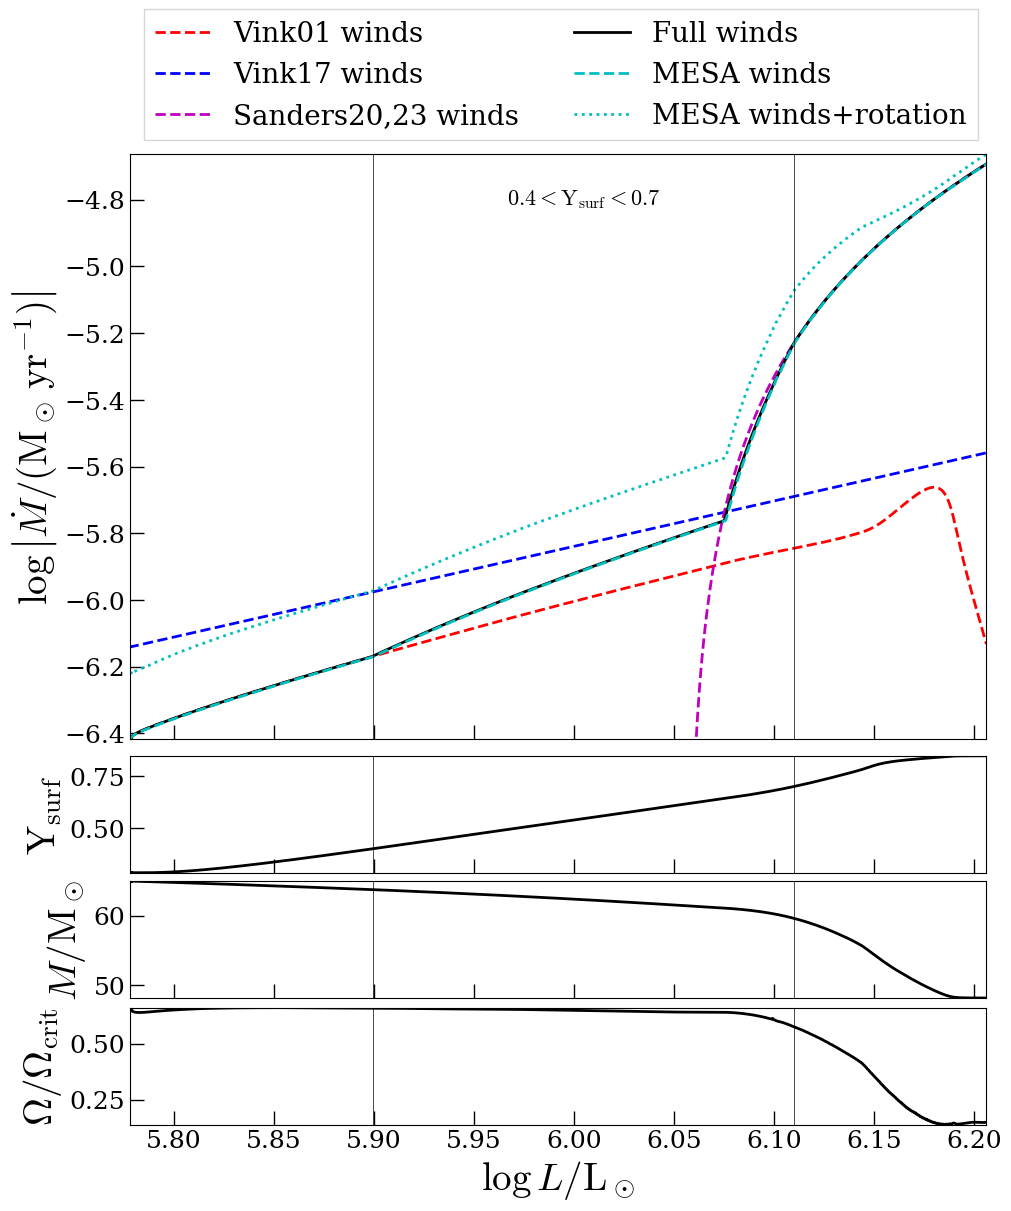

In [80]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'fiducial_089')

In [68]:
wind_test_model = model_dicts[0]['65.0']['1.28']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.001

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/3424198802.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_1825401/3424198802.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


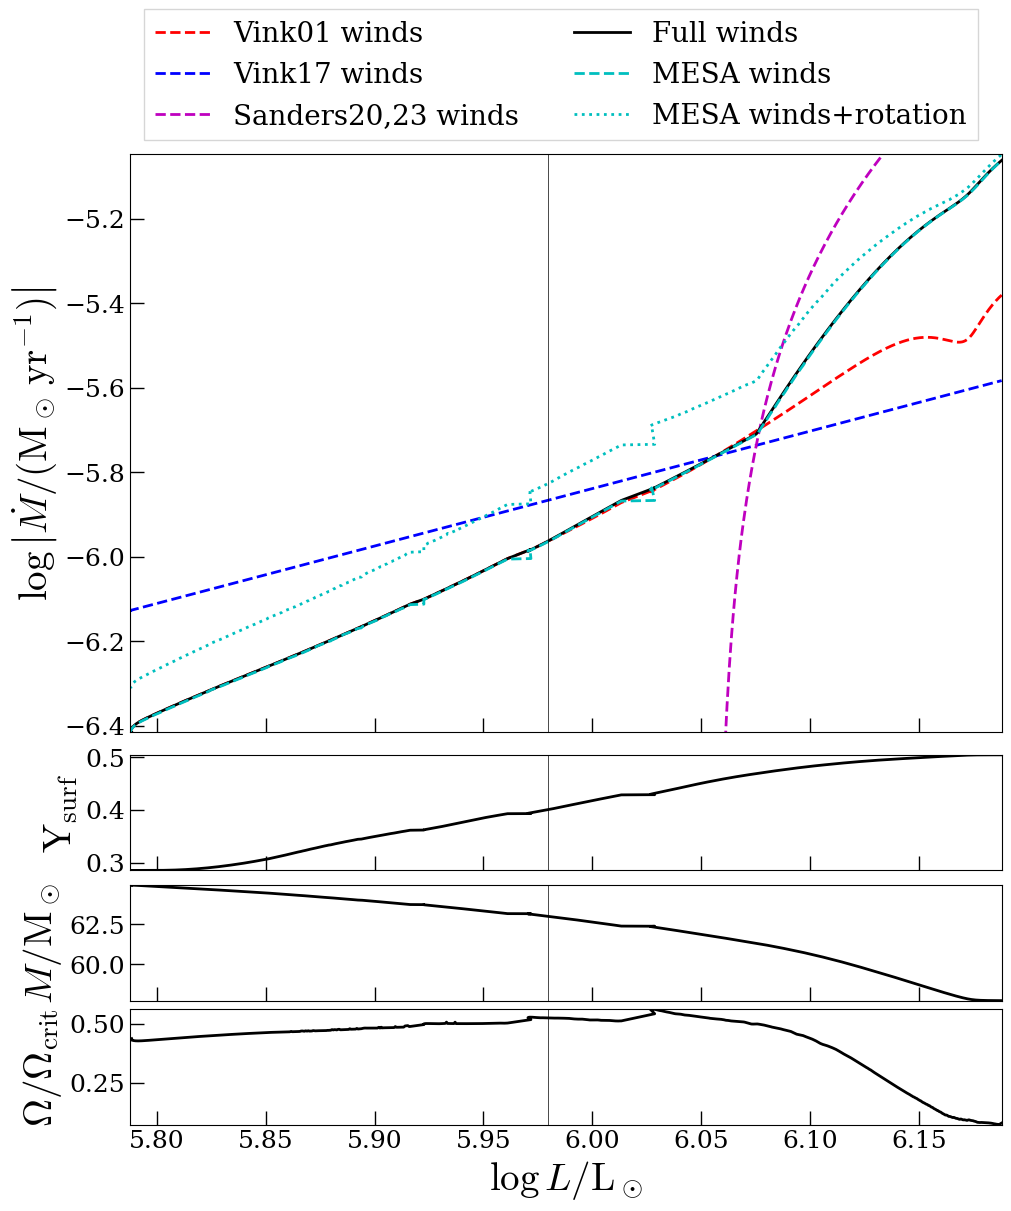

In [69]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
         #va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'fiducial_128')

In [70]:
wind_test_model = model_dicts[0]['65.0']['1.65']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.001

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/1217986125.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_1825401/1217986125.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


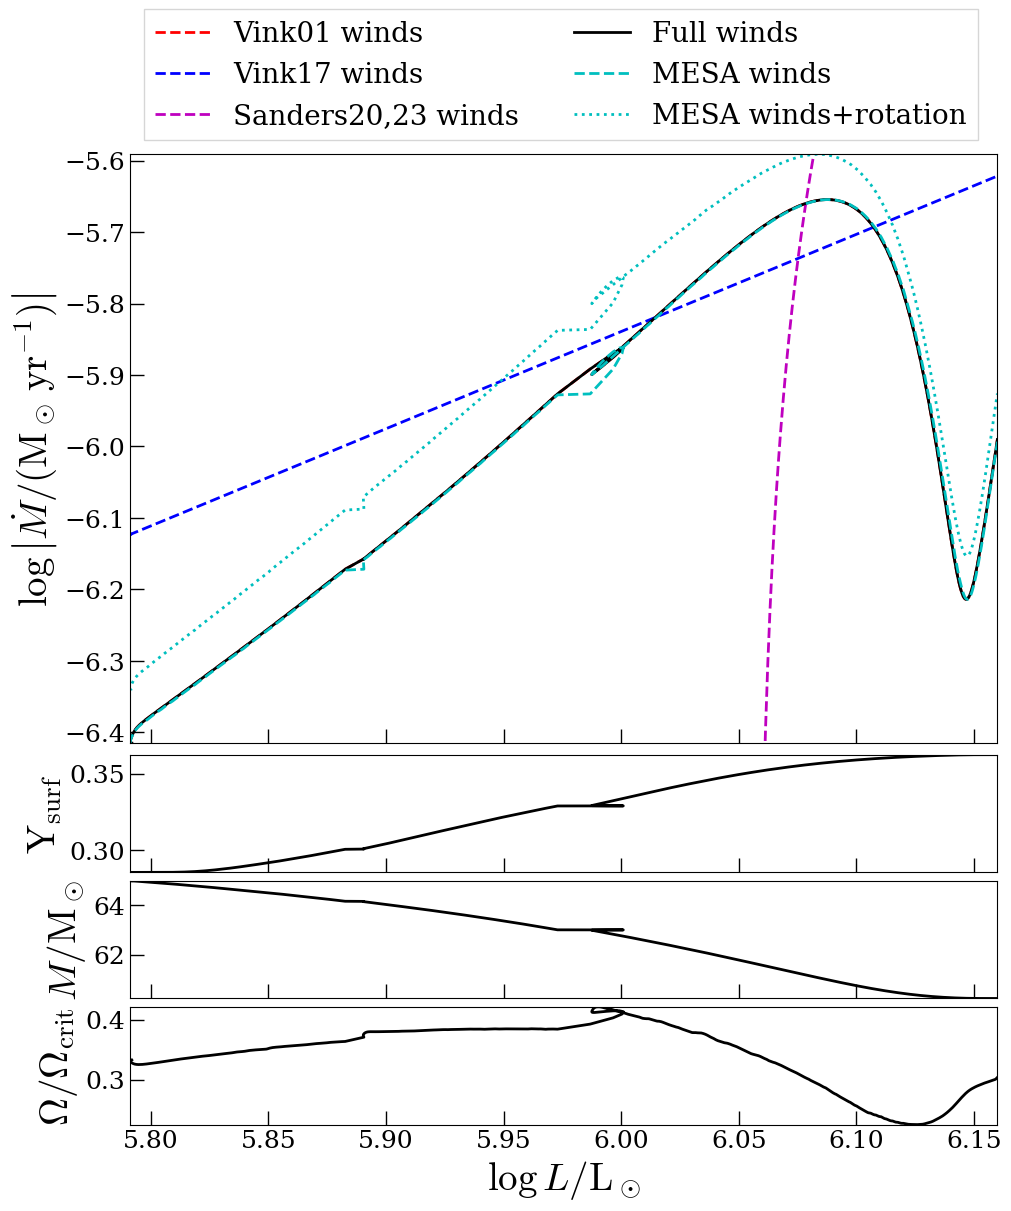

In [71]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'fiducial_165')

In [72]:
wind_test_model = model_dicts[0]['65.0']['2.80']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.001

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/4259609855.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_1825401/4259609855.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


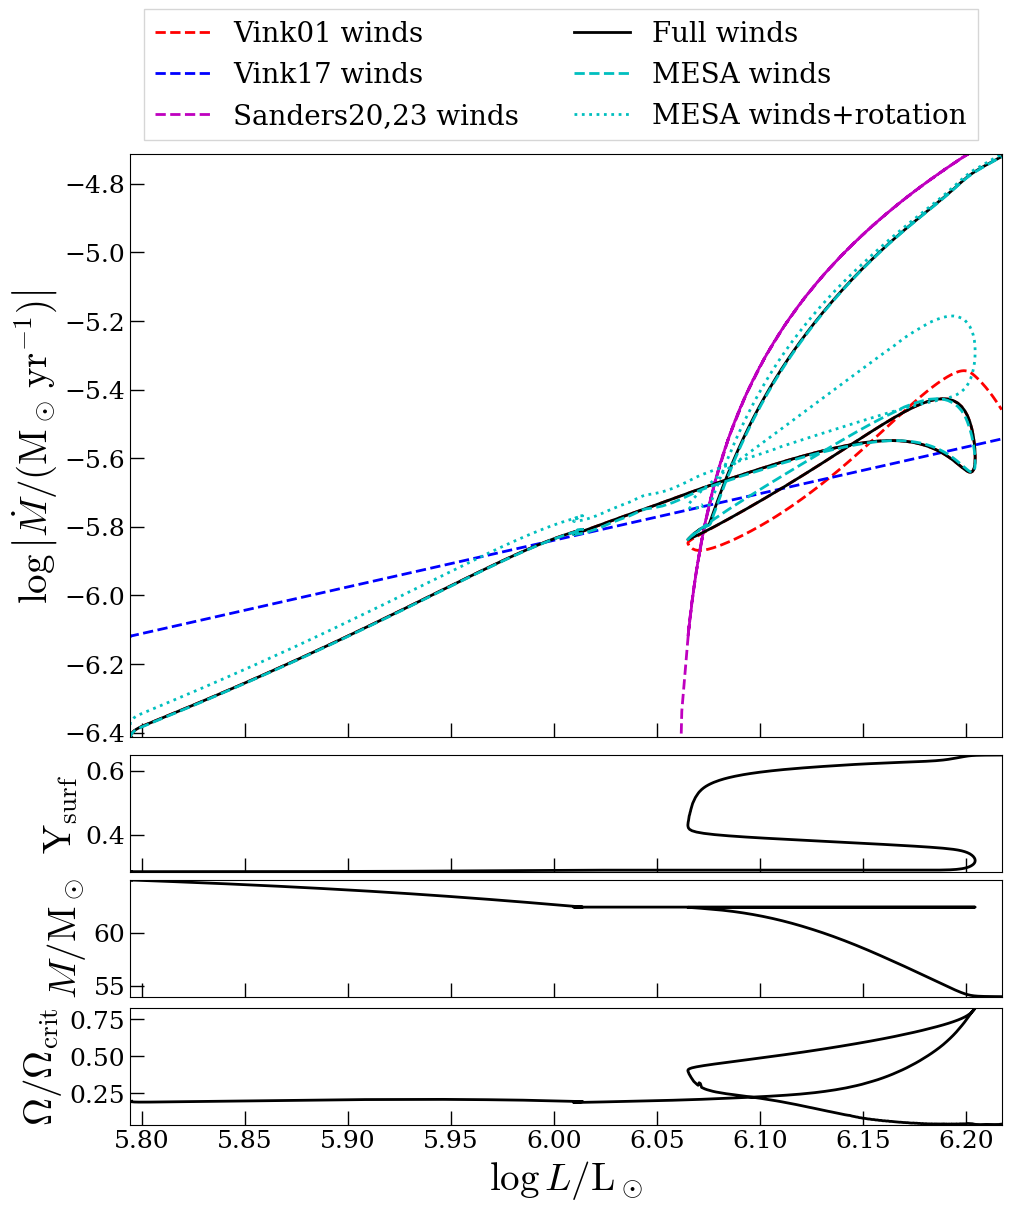

In [73]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
         #va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'fiducial_280')

In [101]:
wind_test_model = model_dicts[0]['65.0']['4.04']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.001

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/1790057032.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_1825401/1790057032.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


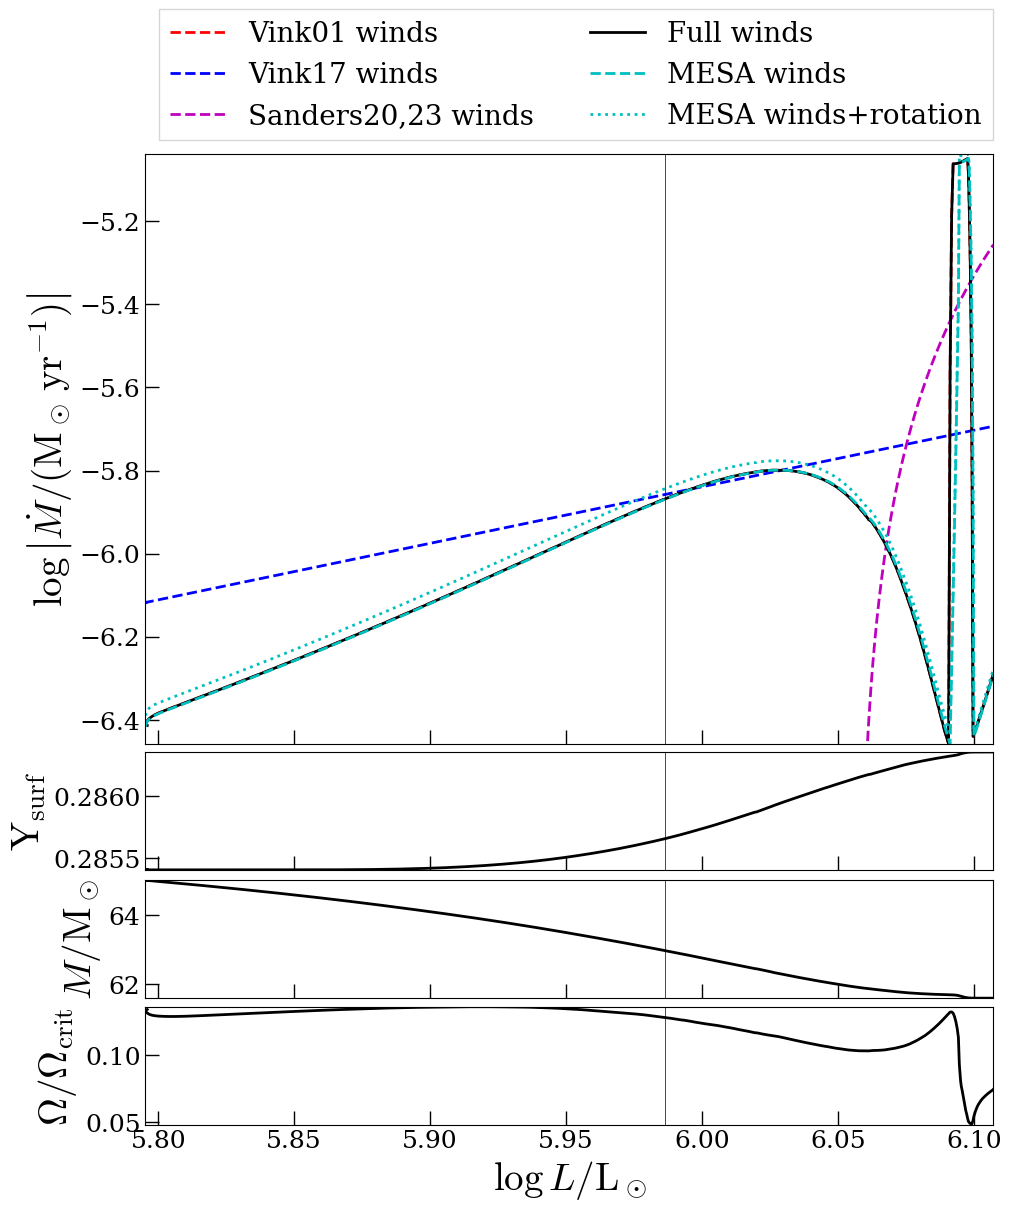

In [102]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'fiducial_404')

#### Solar metallicity

In [109]:
wind_test_model = model_dicts[3]['65.0']['0.89']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/56868119.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


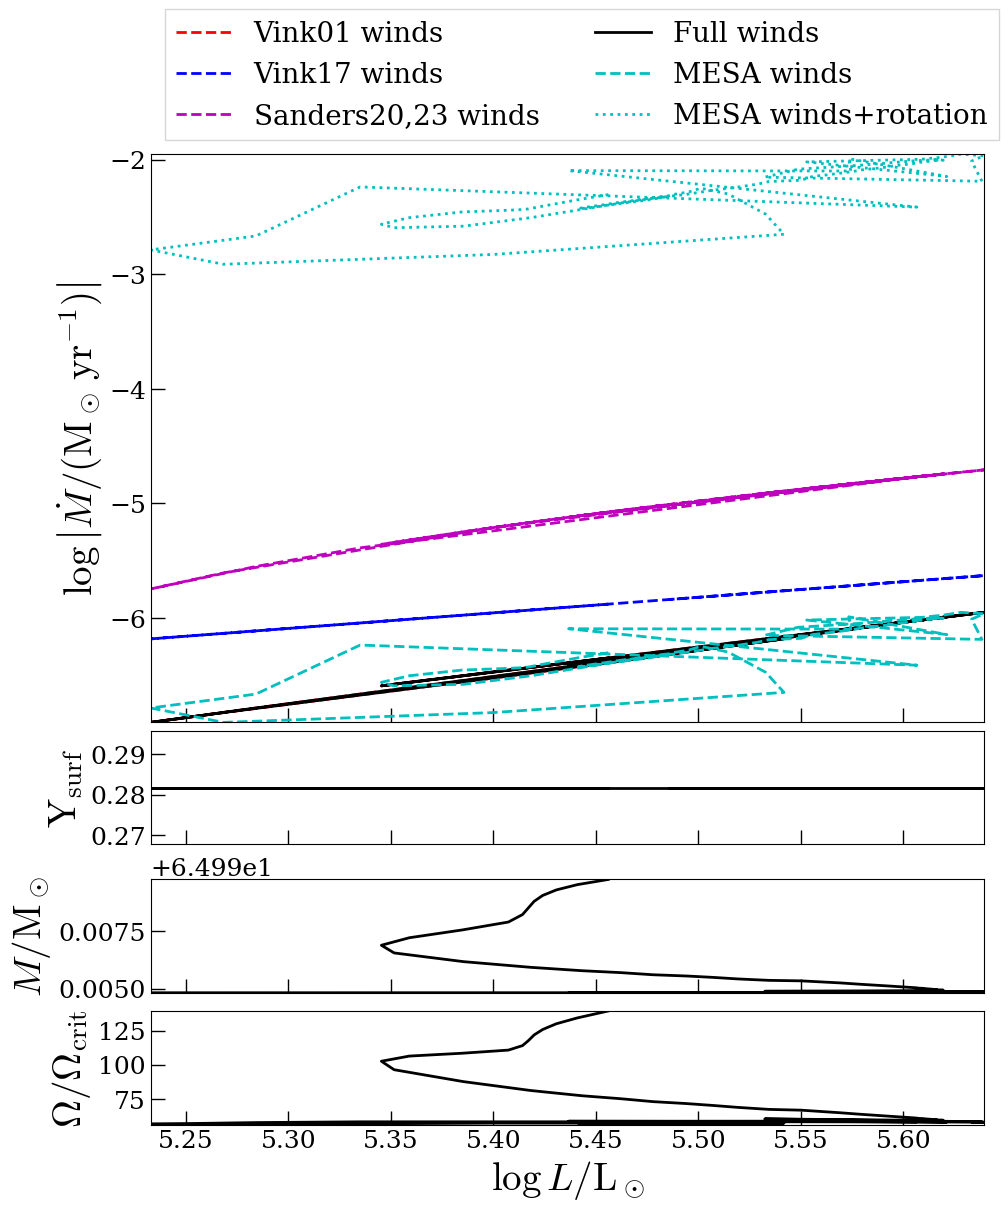

In [110]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
         #va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'solar_089')

In [122]:
wind_test_model = model_dicts[3]['65.0']['1.28']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/56868119.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


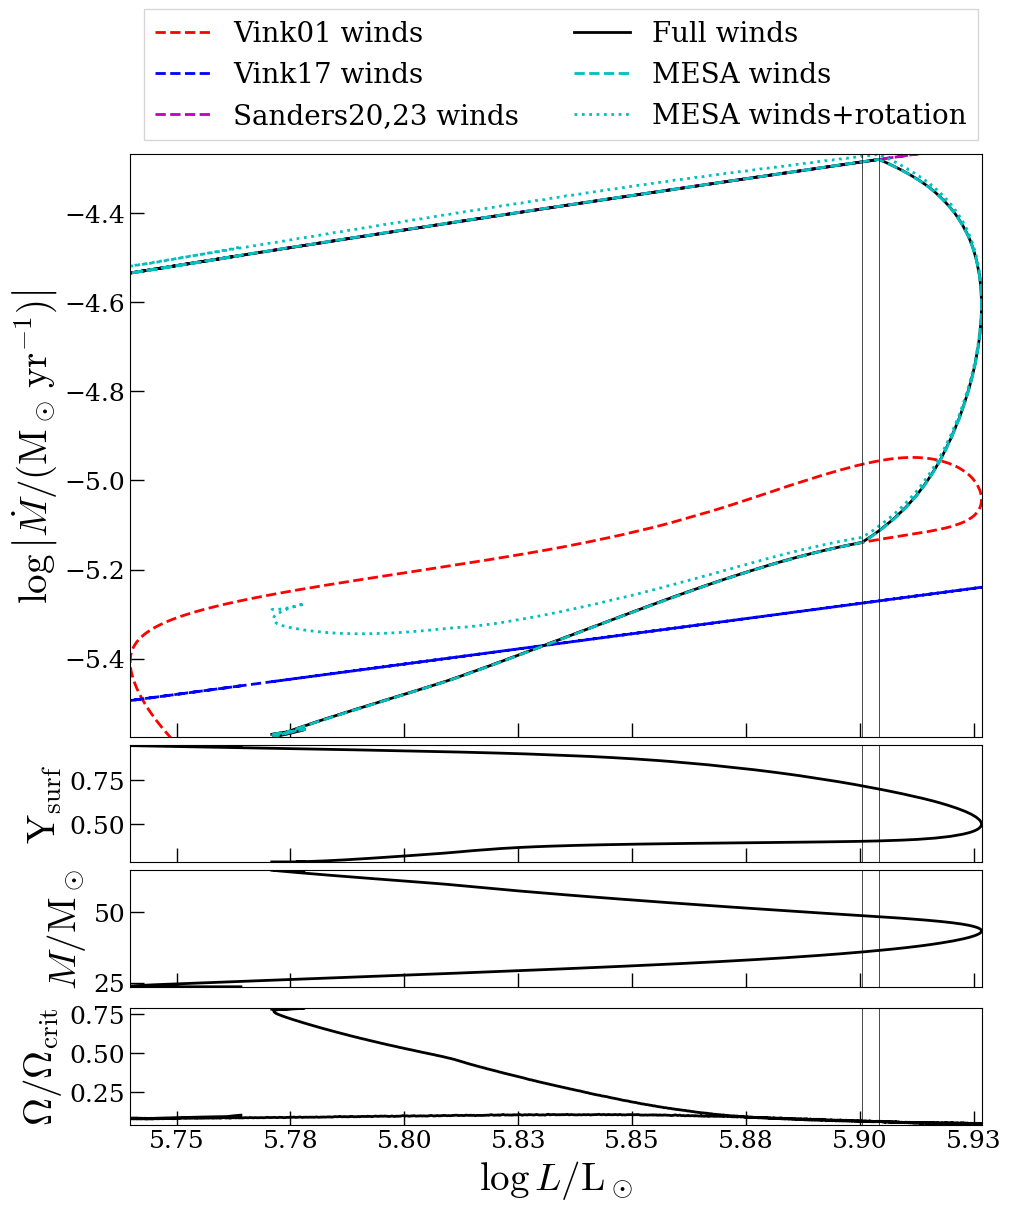

In [123]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
         #va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'solar_089')

In [111]:
wind_test_model = model_dicts[3]['65.0']['1.28']

wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/3538006784.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


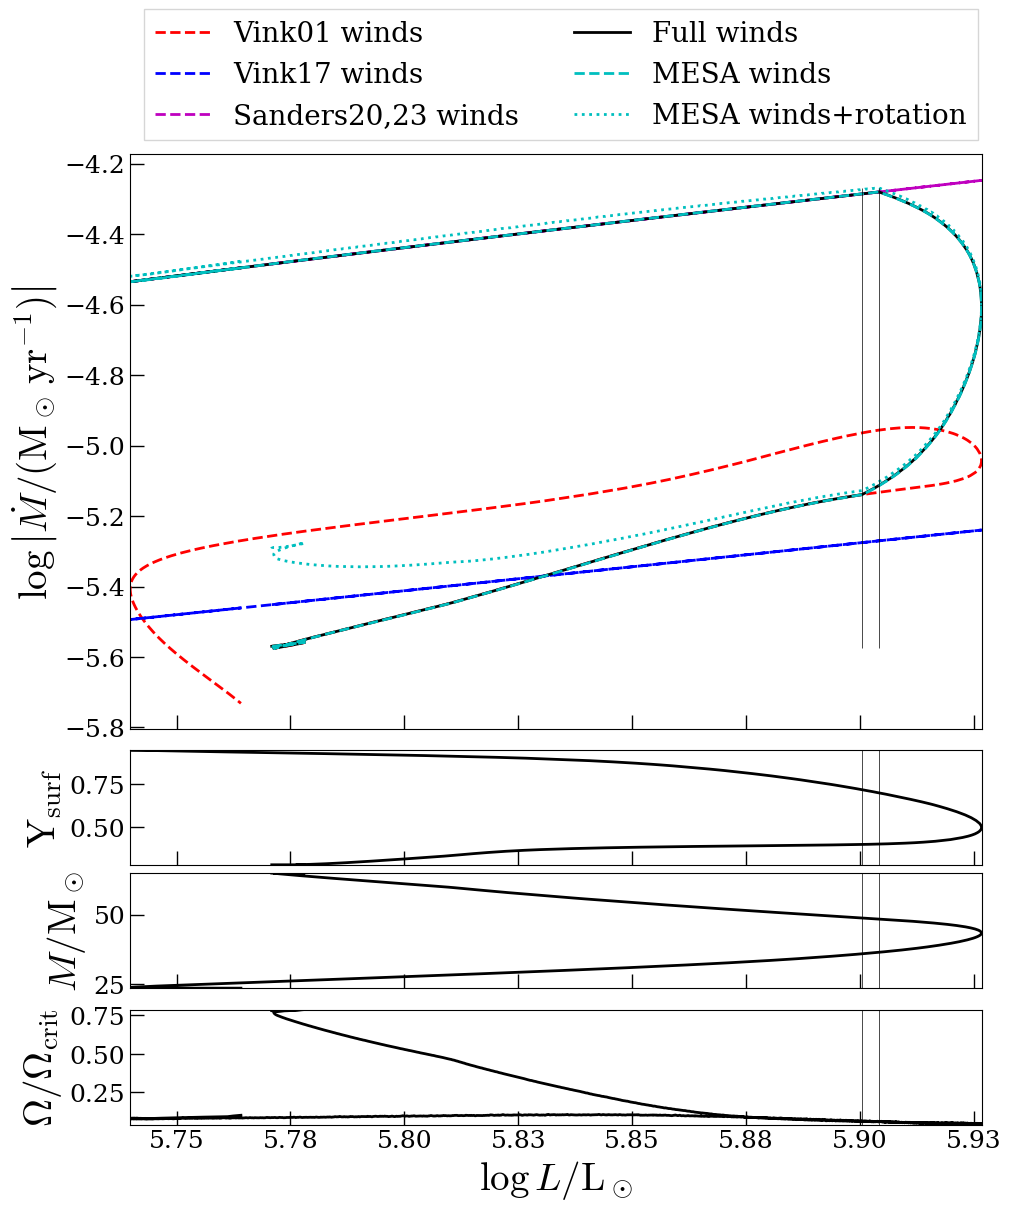

In [112]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
         #va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
#ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'solar_128')

In [113]:
wind_test_model = model_dicts[3]['65.0']['1.65']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/1172953437.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


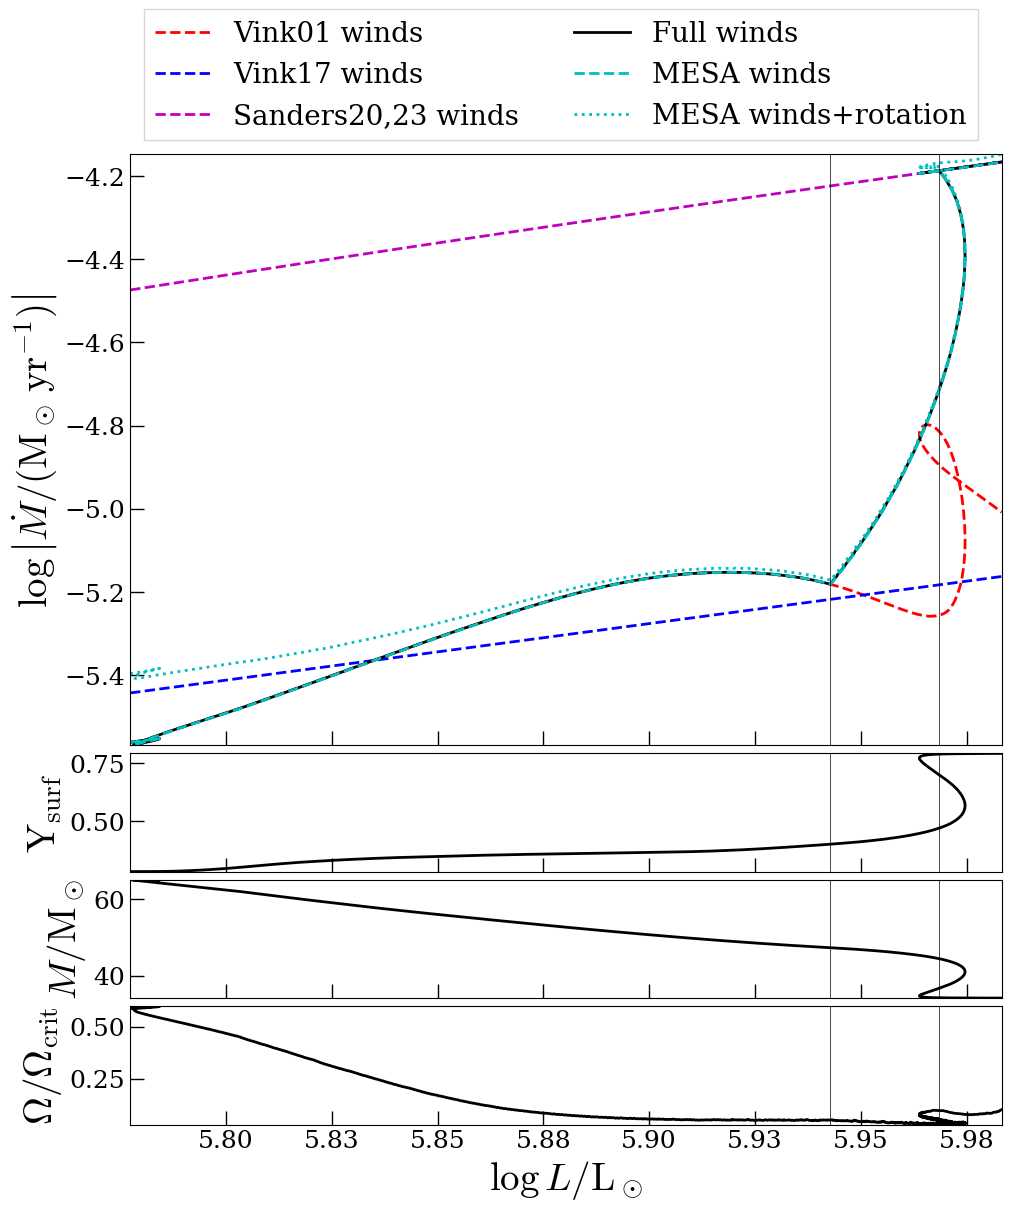

In [114]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'solar_165')

In [124]:
wind_test_model = model_dicts[3]['65.0']['2.80']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/2144092086.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


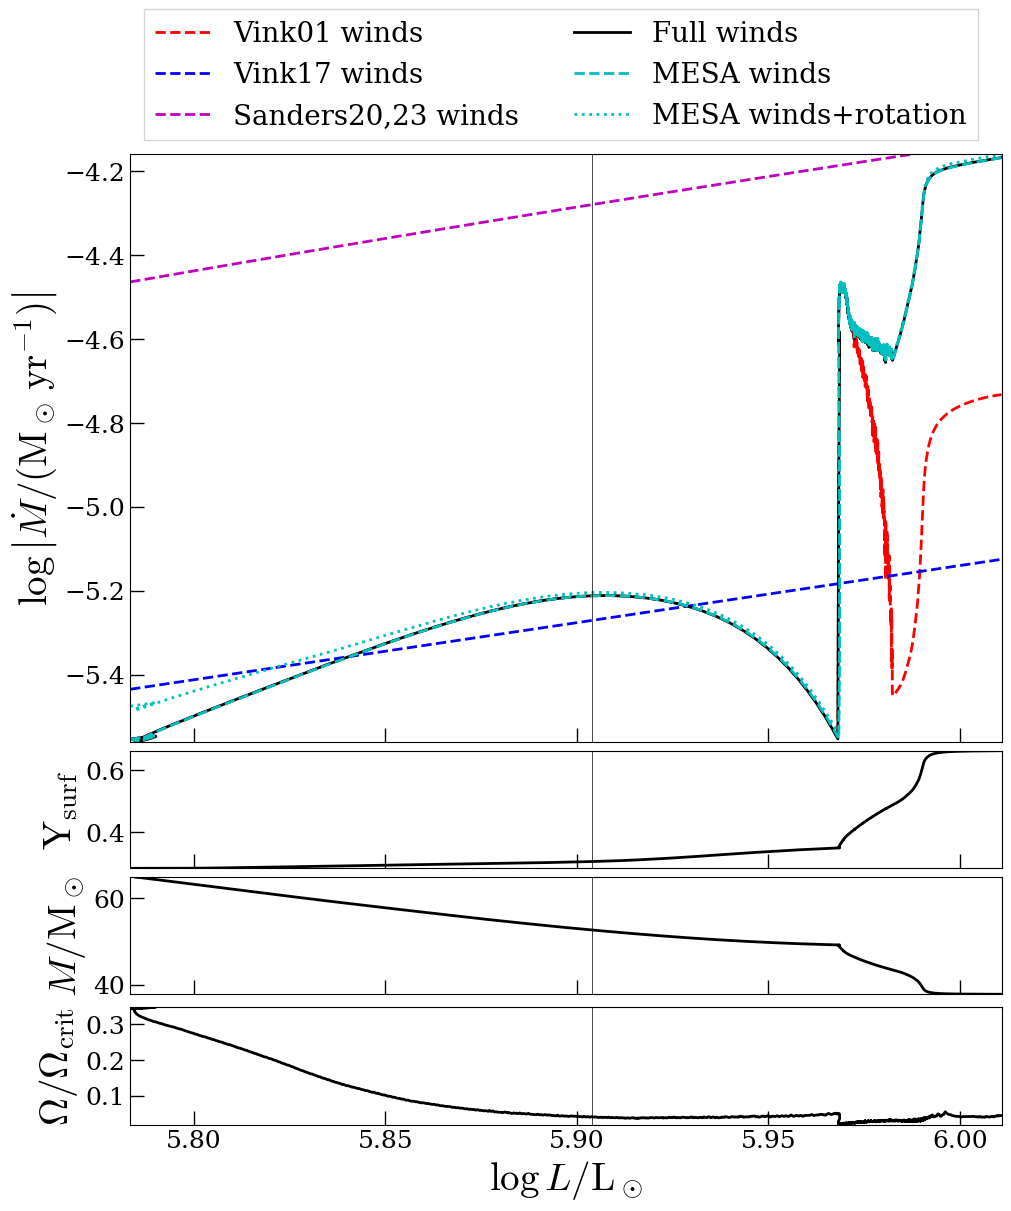

In [125]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'solar_280')

In [126]:
wind_test_model = model_dicts[3]['65.0']['4.04']


wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1825401/2051173710.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


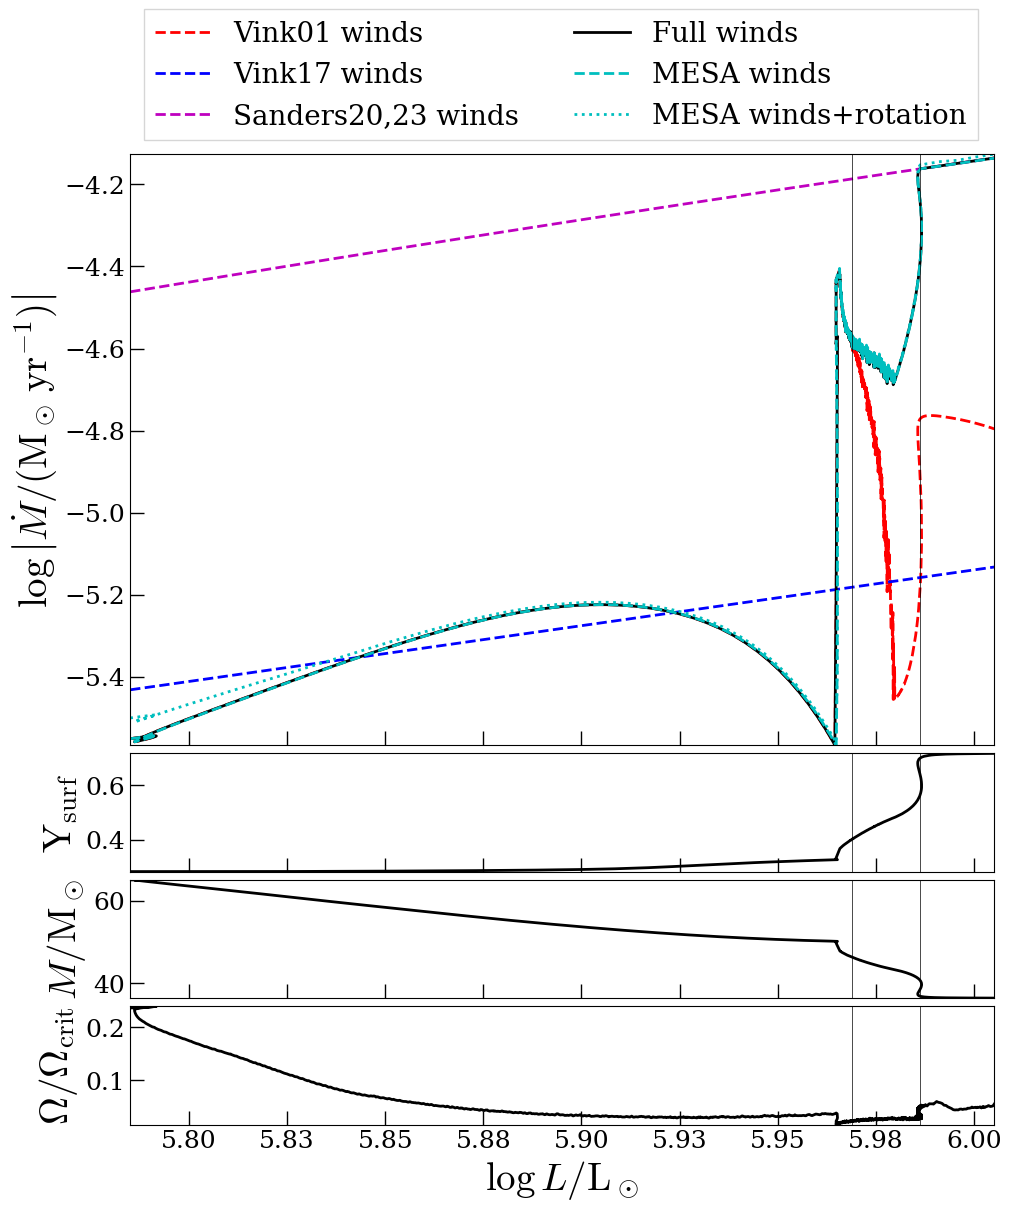

In [127]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
         #va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'solar_404')

## History plots

### HR Diagram

#### All periods per resolution

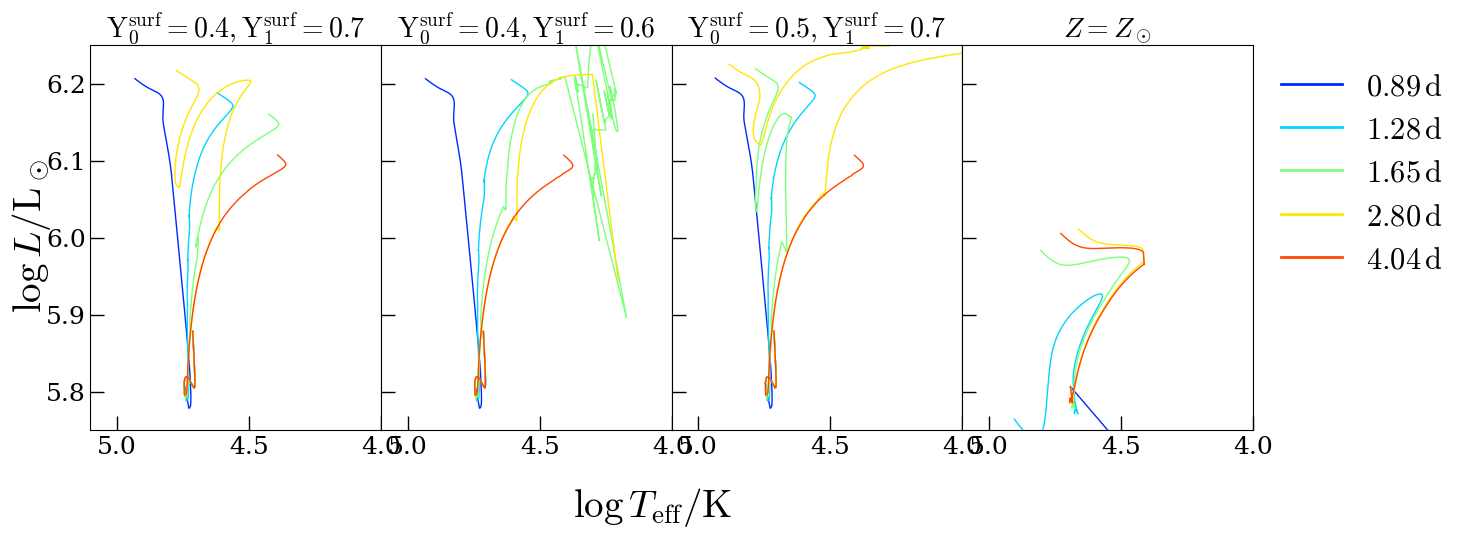

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

models_to_plot = [0, 1, 2, 3]

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = len(model_dict_list) * ['-']

for i, (ax, model_dict, model_label, model_style) in enumerate(zip(axes, model_dict_list, model_label_list, model_style_list)):
    if i == len(model_dict_list)-1:
        label_period = True
    else:
        label_period = False
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=[model_dict],
        model_styles=[model_style],
        model_labels=[model_label],
        title=True,
        label_period=label_period
    )
    history_plot(ax, **settings)
    
for ax in axes:
    ax.tick_params(direction='in')
    ax.set_ylim(5.75, 6.25)
    ax.set_xlim(5.1, 4)

fig.text(0.5, 0, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center', transform=fig.transFigure)
fig.text(0.1, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right', transform=fig.transFigure)

savefig(fig, 'hr_res_panels')   

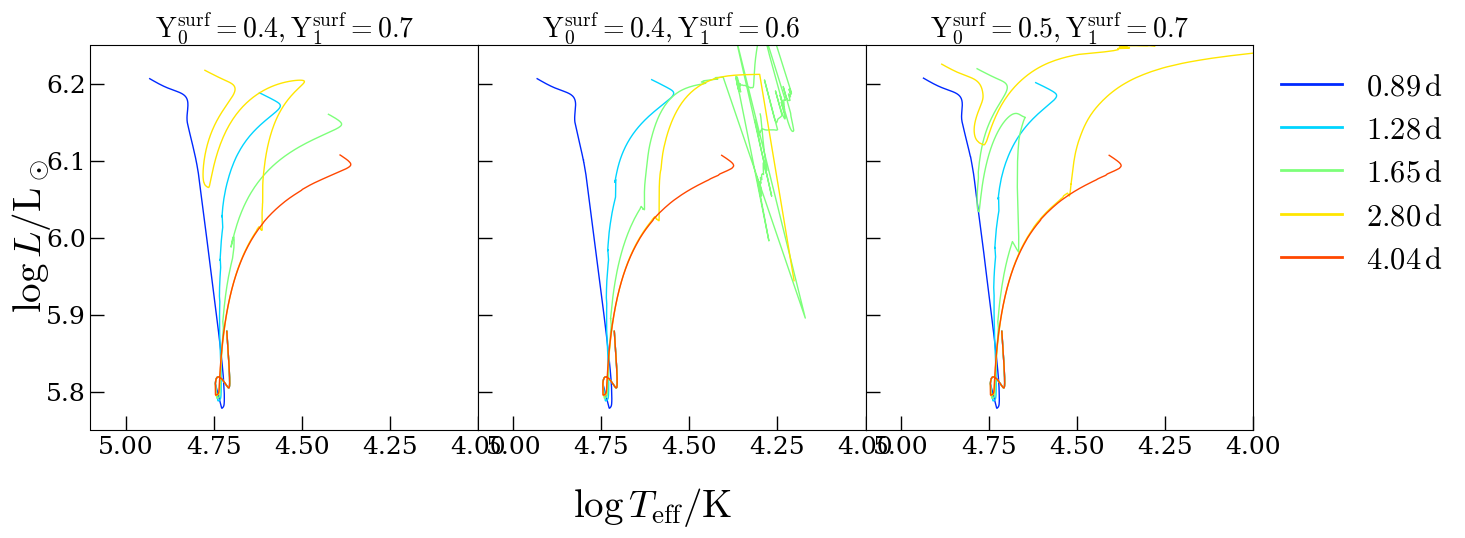

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

models_to_plot = [0, 1, 2]

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = len(model_dict_list) * ['-']

for i, (ax, model_dict, model_label, model_style) in enumerate(zip(axes, model_dict_list, model_label_list, model_style_list)):
    if i == len(model_dict_list)-1:
        label_period = True
    else:
        label_period = False
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=[model_dict],
        model_styles=[model_style],
        model_labels=[model_label],
        title=True,
        label_period=label_period
    )
    history_plot(ax, **settings)
    
for ax in axes:
    ax.tick_params(direction='in')
    ax.set_ylim(5.75, 6.25)
    ax.set_xlim(5.1, 4)

fig.text(0.5, 0, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center', transform=fig.transFigure)
fig.text(0.1, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right', transform=fig.transFigure)

savefig(fig, 'hr_res_panels')   

### Helium fraction

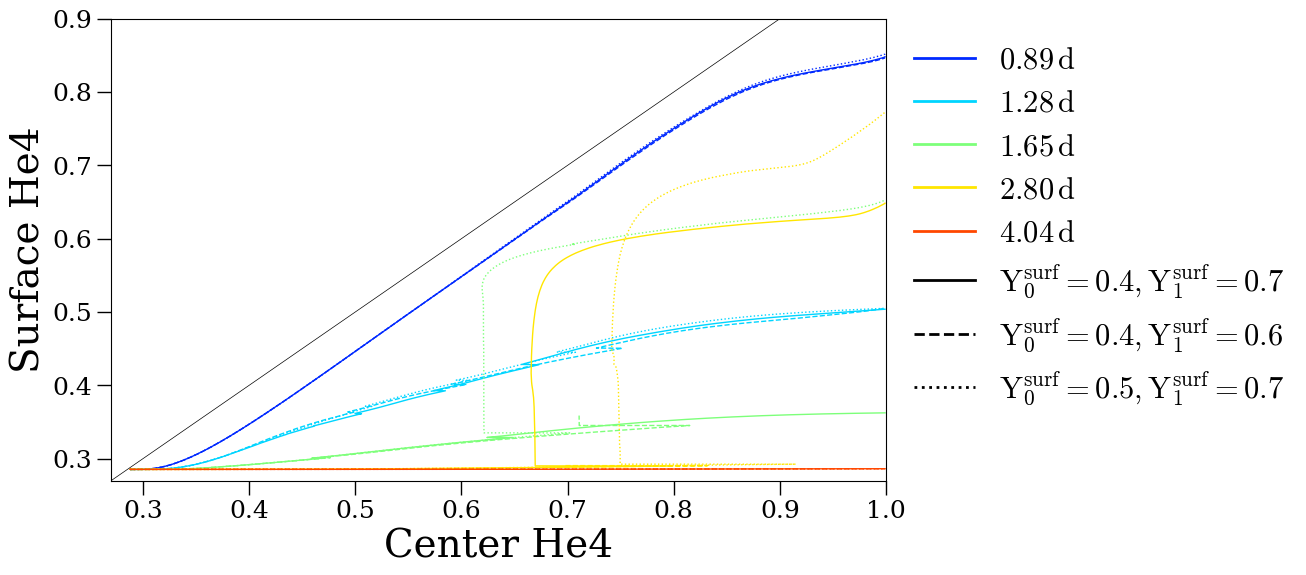

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

models_to_plot = [0, 1, 2]

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', ':']

settings = dict(
    x='center_he4',
    y='surface_he4',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list
)

ax = history_plot(ax, **settings)
xlim = (0.27, 1)
ylim = (0.27, 0.9)
ax.plot(np.linspace(xlim[0], xlim[1], 10), np.linspace(xlim[0], xlim[1], 10), 'k-', lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)


ax.set_xlabel('Center He4')
ax.set_ylabel('Surface He4')

savefig(fig, 'hist_he4_ev')


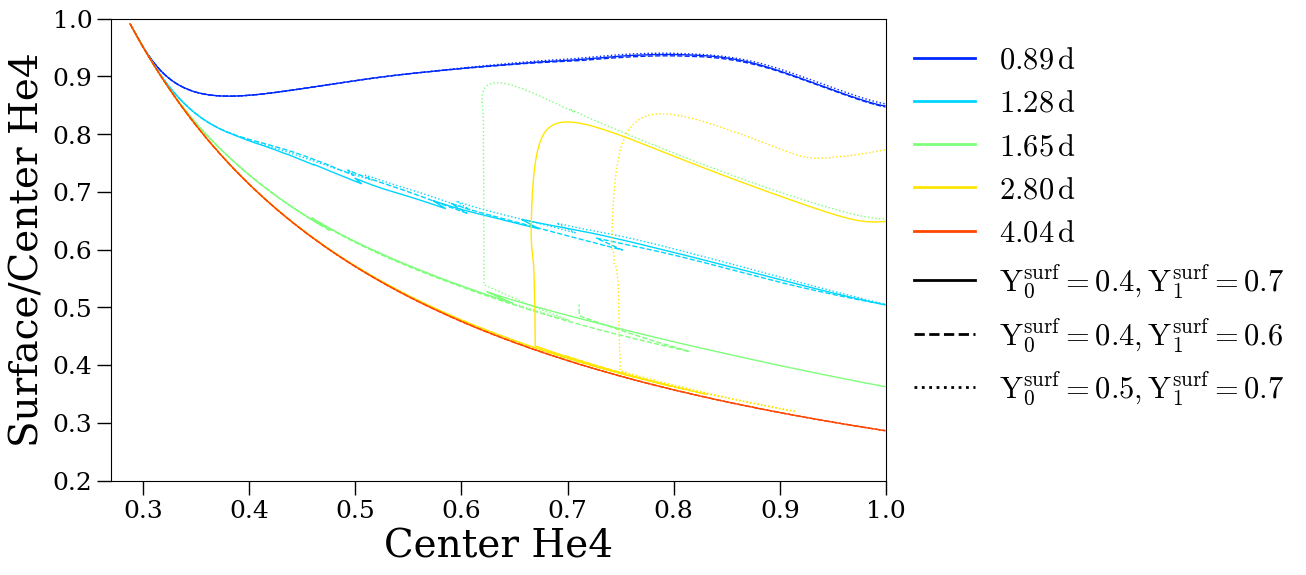

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', ':']

settings = dict(
    x='center_he4',
    y='surface_he4/center_he4',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list
)

ax = history_plot(ax, **settings)
xlim = (0.27, 1)
ylim = (0.2, 1)
#ax.plot(np.linspace(xlim[0], xlim[1], 10), np.linspace(xlim[0], xlim[1], 10), 'k-', lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)


ax.set_xlabel('Center He4')
ax.set_ylabel('Surface/Center He4')

savefig(fig, 'hist_he4surf_div_he4center_ev')


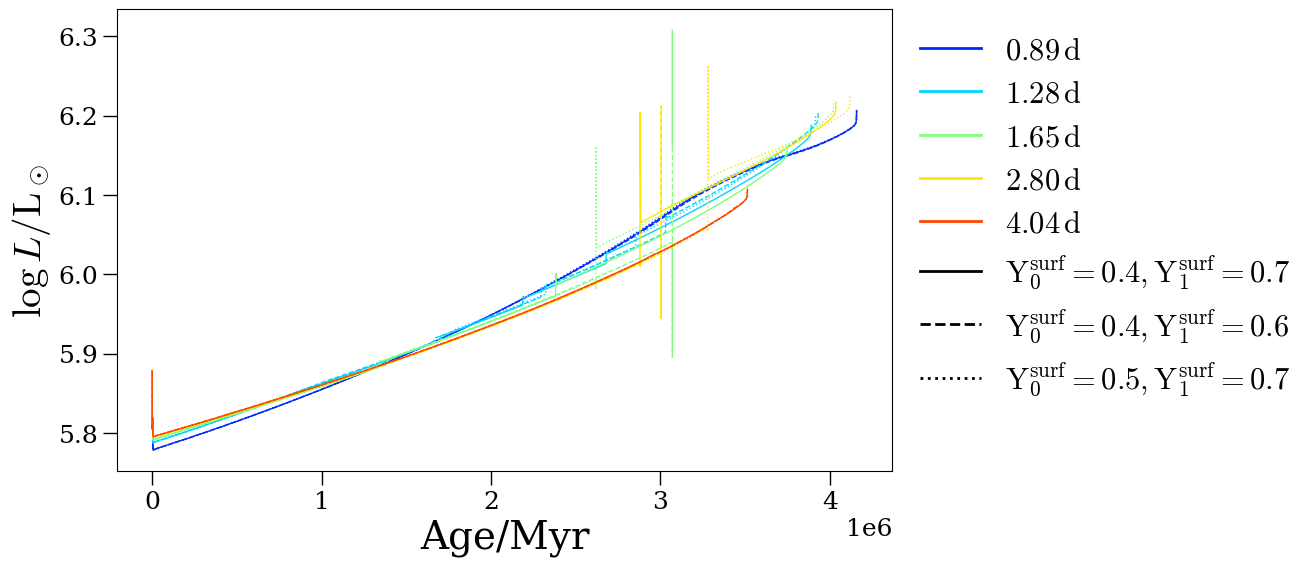

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', ':']

settings = dict(
    x='star_age',
    y='log_L',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list
)

ax = history_plot(ax, **settings)
#xlim = (0.27, 1)
#ylim = (0.27, 0.9)
#ax.plot(np.linspace(xlim[0], xlim[1], 10), np.linspace(xlim[0], xlim[1], 10), 'k-', lw=0.5)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)


ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

savefig(fig, 'hist_logL_ev')


### Number of cells

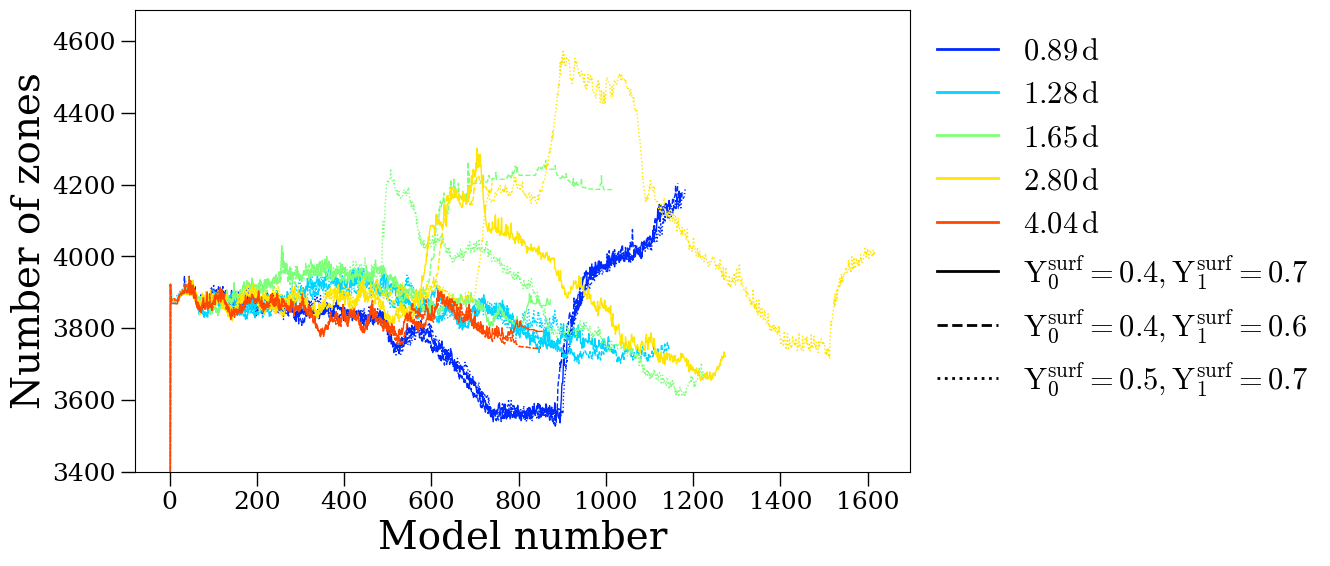

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', ':']

settings = dict(
    x='model_number',
    y='num_zones',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Model number')
ax.set_ylabel('Number of zones')
ax.set_ylim(3400)


savefig(fig, 'hist_no_cells_ev')


### Rotation and radius

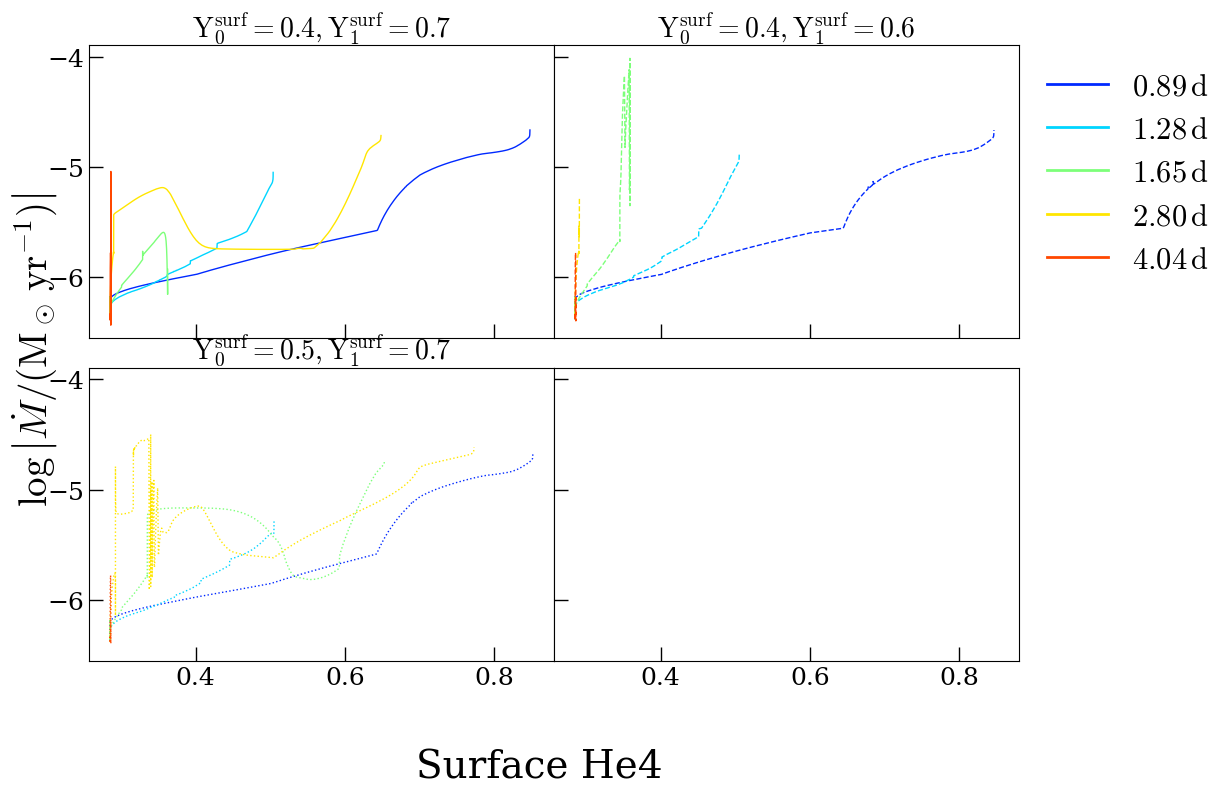

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(wspace=0, hspace=0.1)

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', ':']

for i, (ax, model_dict, model_label, model_style) in enumerate(zip(axes, model_dict_list, model_label_list, model_style_list)):
    if i == 1:
        label_period = True
    else:
        label_period = False
    settings = dict(
        x='surface_he4',
        y='log_abs_mdot',
        invert_xaxis=False,
        invert_yaxis=False,
        model_dict_list=[model_dict],
        model_styles=[model_style],
        model_labels=[model_label],
        title=True,
        label_period=label_period
    )
    history_plot(ax, **settings)
    
for ax in axes:
    ax.tick_params(direction='in')
    #ax.set_ylim(5.75, 6.25)
    #ax.set_xlim(5, 4)

fig.text(0.5, 0, 'Surface He4', va='top', ha='center', transform=fig.transFigure)
fig.text(0.1, 0.5, '$\\log\\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$', rotation=90, va='center', ha='right', transform=fig.transFigure)

savefig(fig, 'mdot_surfacehe4_res_panels')   

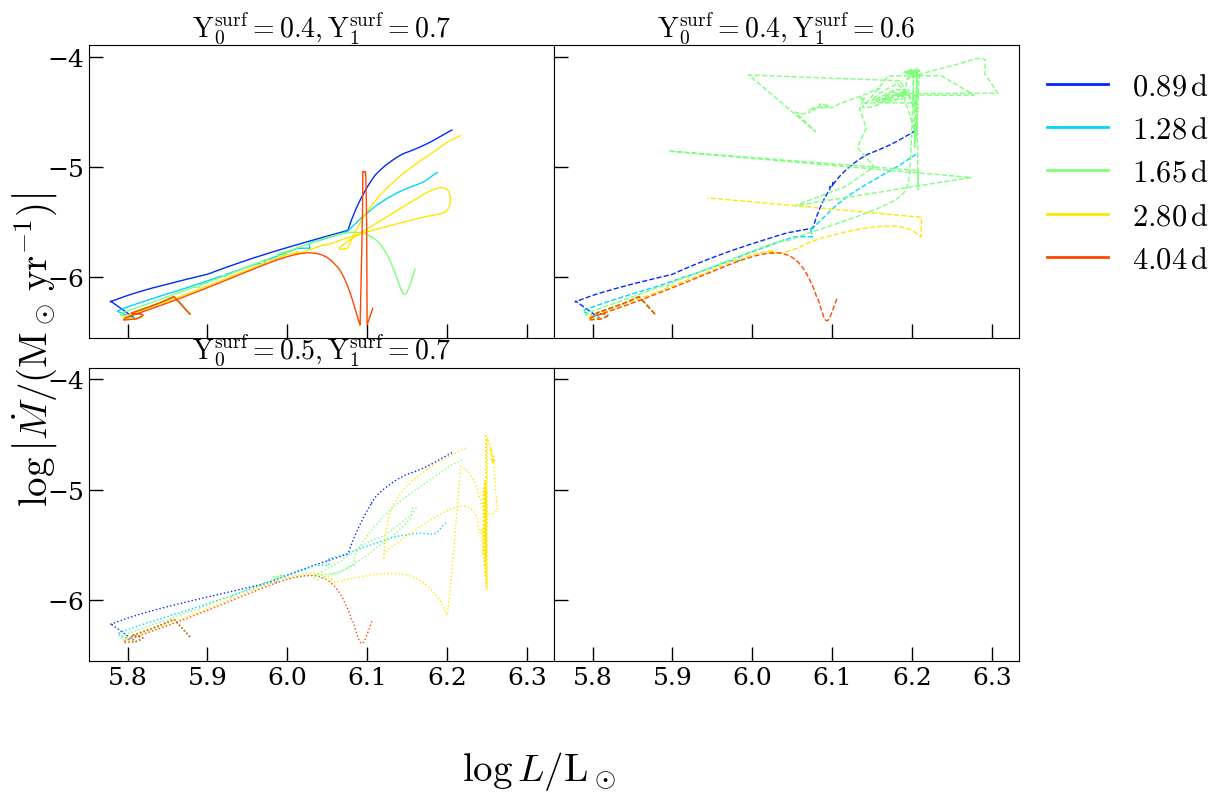

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(wspace=0, hspace=0.1)

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', ':']

for i, (ax, model_dict, model_label, model_style) in enumerate(zip(axes, model_dict_list, model_label_list, model_style_list)):
    if i == 1:
        label_period = True
    else:
        label_period = False
    settings = dict(
        x='log_L',
        y='log_abs_mdot',
        invert_xaxis=False,
        invert_yaxis=False,
        model_dict_list=[model_dict],
        model_styles=[model_style],
        model_labels=[model_label],
        title=True,
        label_period=label_period
    )
    history_plot(ax, **settings)
    
for ax in axes:
    ax.tick_params(direction='in')
    #ax.set_ylim(5.75, 6.25)
    #ax.set_xlim(5, 4)

fig.text(0.5, 0, '$\\log L/\\mathrm{L}_\\odot$', va='top', ha='center', transform=fig.transFigure)
fig.text(0.1, 0.5, '$\\log\\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$', rotation=90, va='center', ha='right', transform=fig.transFigure)

savefig(fig, 'mdot_surfacehe4_res_panels')   

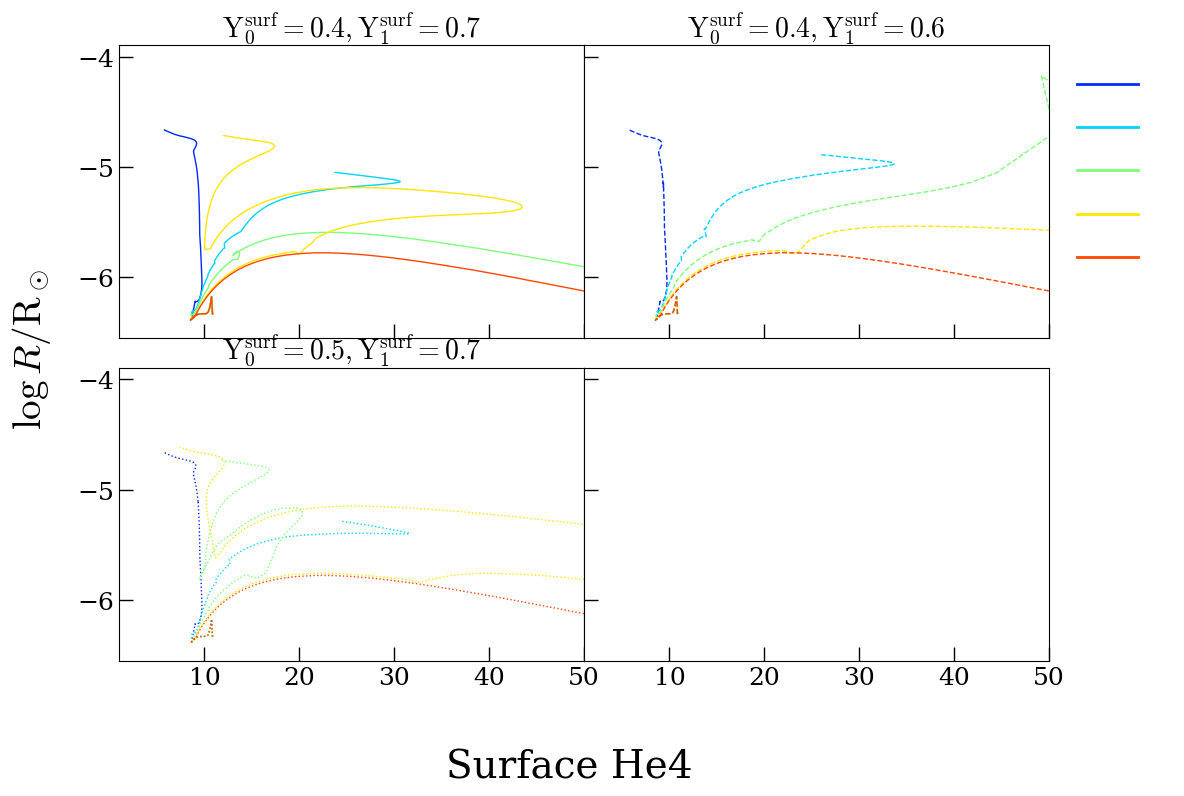

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(wspace=0, hspace=0.1)

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', ':']

for i, (ax, model_dict, model_label, model_style) in enumerate(zip(axes, model_dict_list, model_label_list, model_style_list)):
    if i == len(model_dict_list)-1:
        label_period = True
    else:
        label_period = False
    settings = dict(
        x='radius',
        y='log_abs_mdot',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=[model_dict],
        model_styles=[model_style],
        model_labels=[model_label],
        title=True,
        label_period=label_period
    )
    history_plot(ax, **settings)
    
for ax in axes:
    ax.tick_params(direction='in')
    #ax.set_ylim(5.75, 6.25)
    ax.set_xlim(1, 50)

fig.text(0.5, 0, 'Surface He4', va='top', ha='center', transform=fig.transFigure)
fig.text(0.07, 0.5, '$\\log R/\\mathrm{R}_\\odot$', rotation=90, va='center', ha='right', transform=fig.transFigure)

savefig(fig, 'radius_surfacehe4_res_panels')   

(-6.5, -4.0)

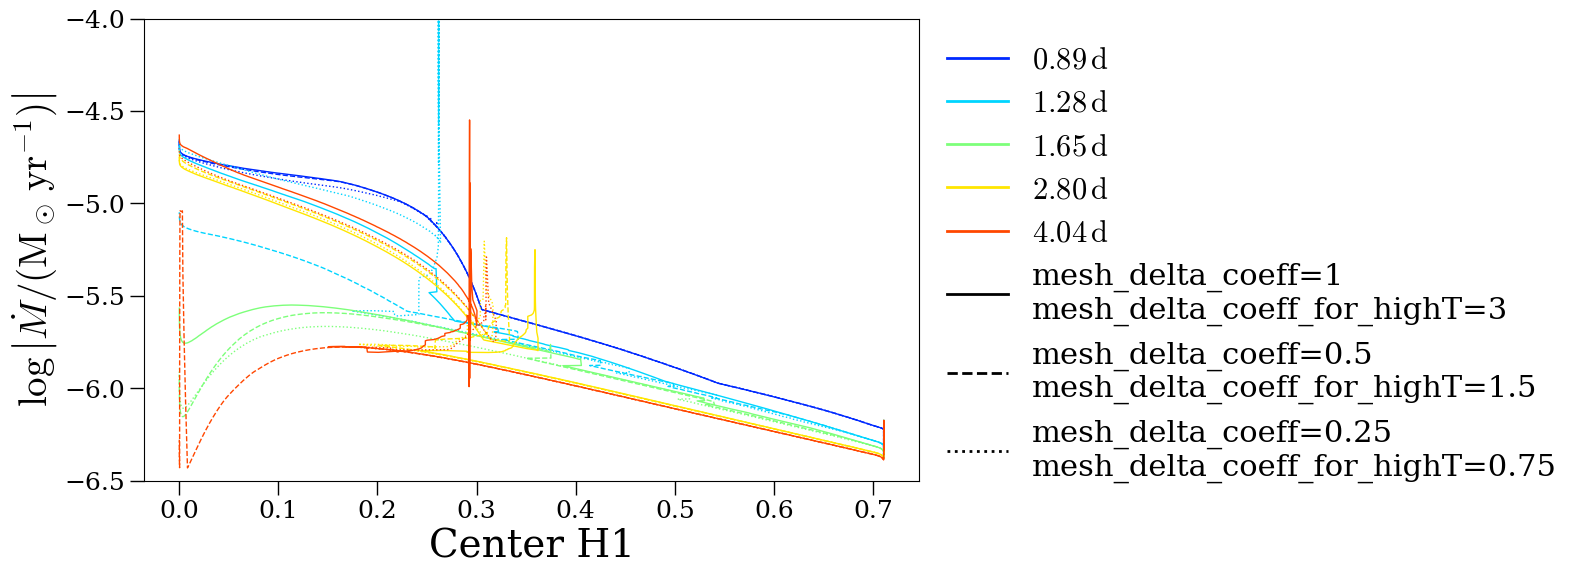

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='center_h1',
    y='log_abs_mdot',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$\\log\\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax.set_ylim(-6.5, -4)

(-6.5, -4.0)

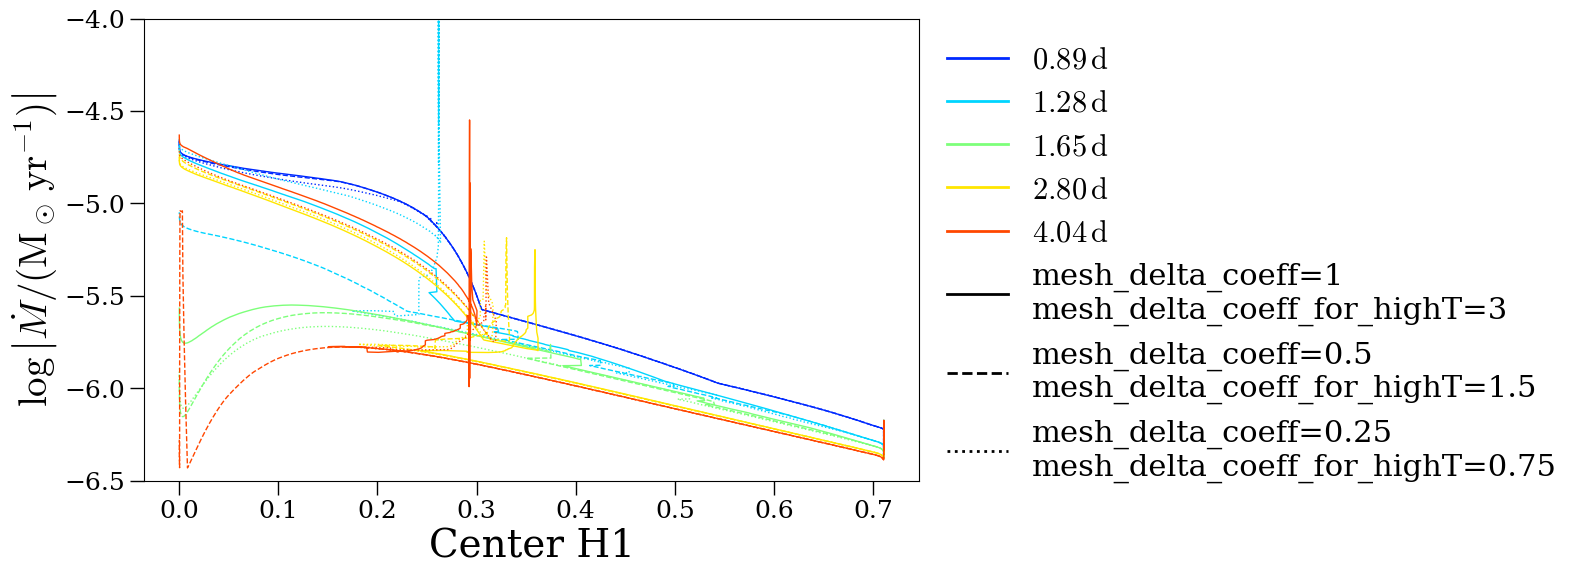

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='center_h1',
    y='log_abs_mdot',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$\\log\\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax.set_ylim(-6.5, -4)

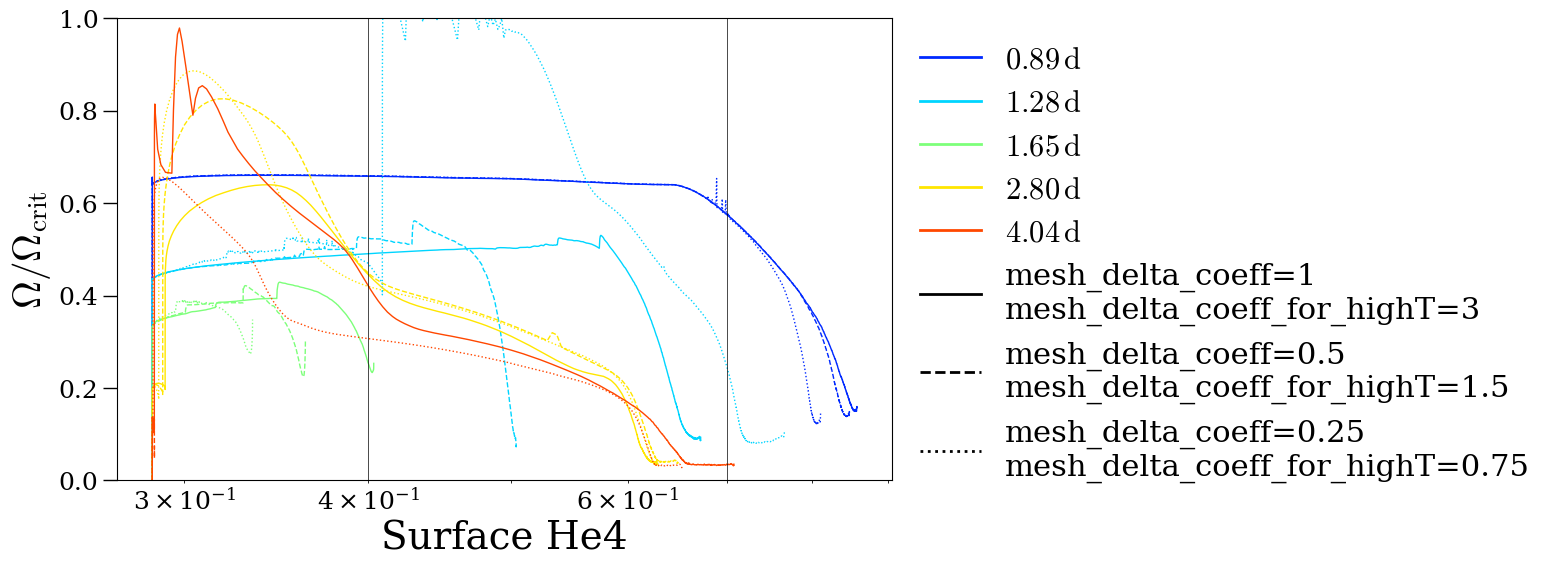

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='surface_he4',
    y='surf_avg_omega_div_omega_crit',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ],
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')

ylim = (0, 1)
ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)
ax.set_xscale('log')

(0.0, 1.0)

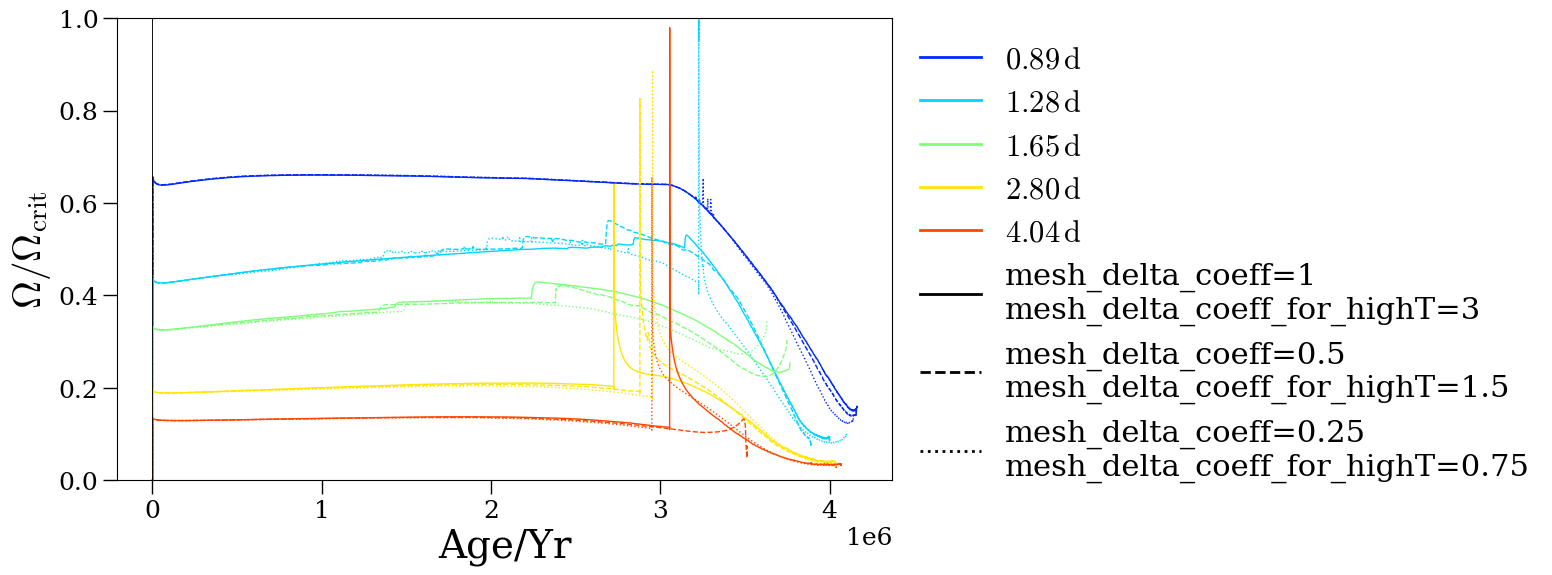

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='star_age',
    y='surf_avg_omega_div_omega_crit',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Age/Yr')
ax.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')

ylim = (0, 1)
ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

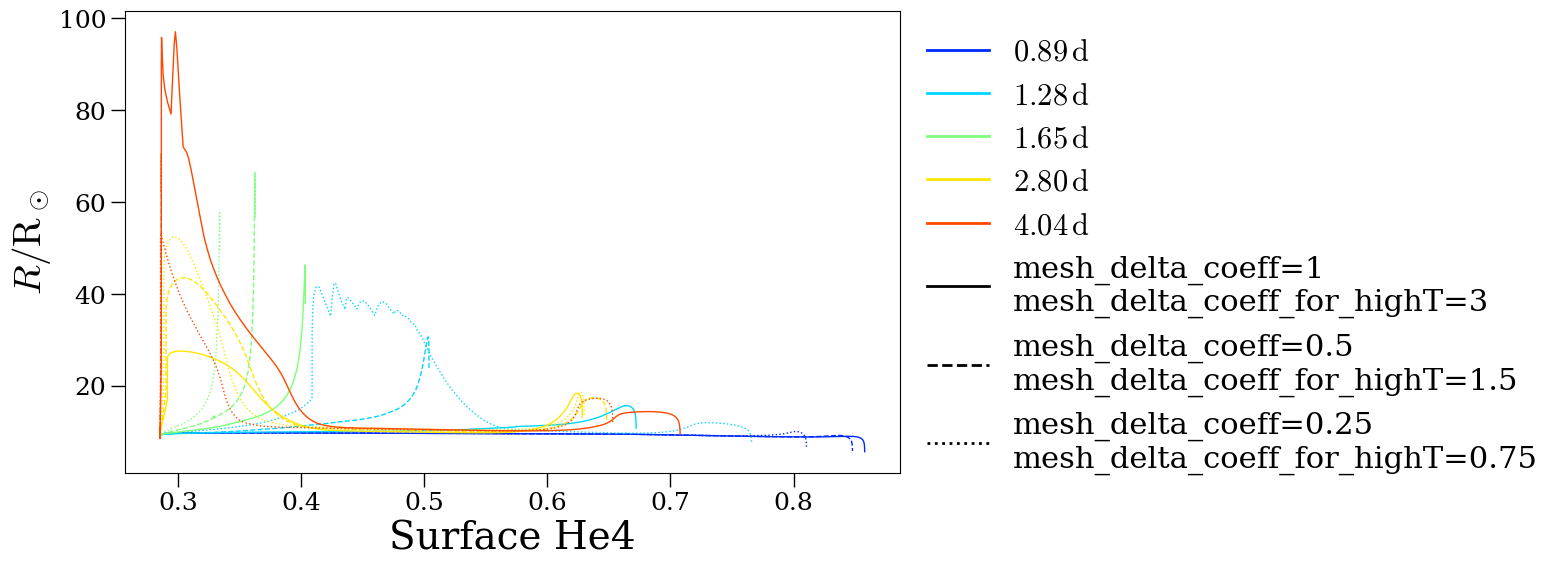

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='surface_he4',
    y='radius',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

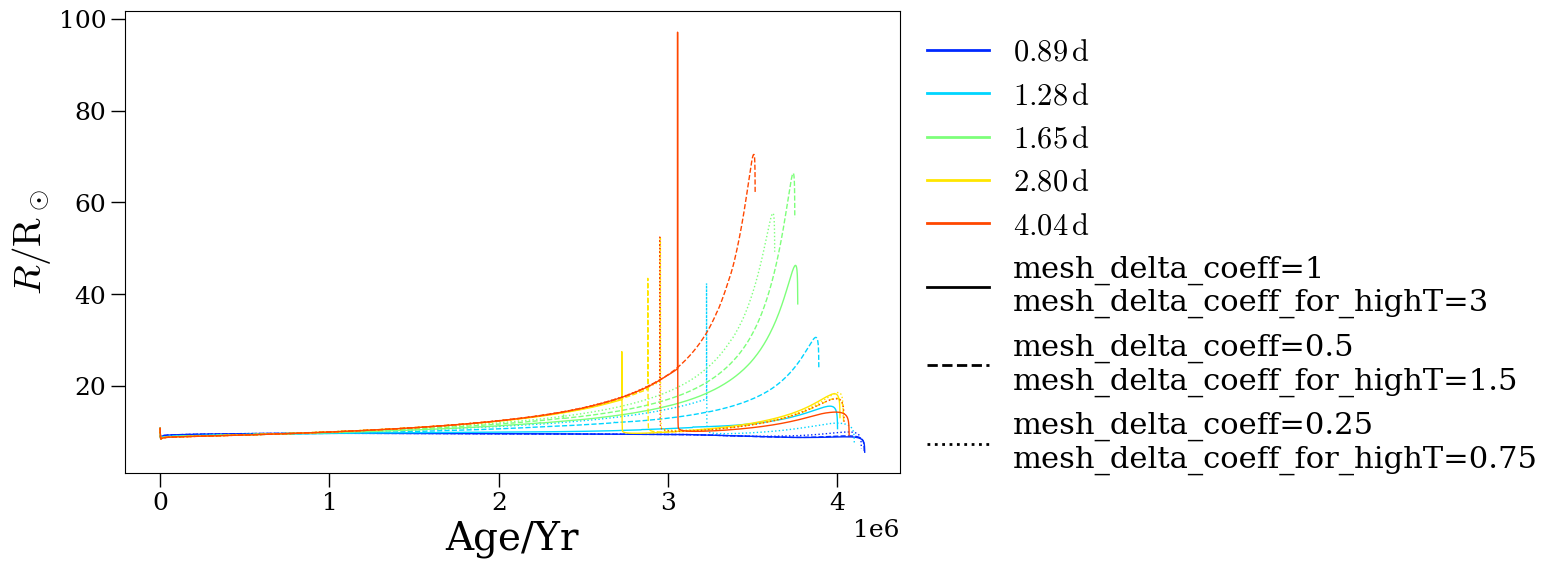

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='star_age',
    y='radius',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Age/Yr')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

Text(0, 0.5, '$M/\\mathrm{M}_\\odot$')

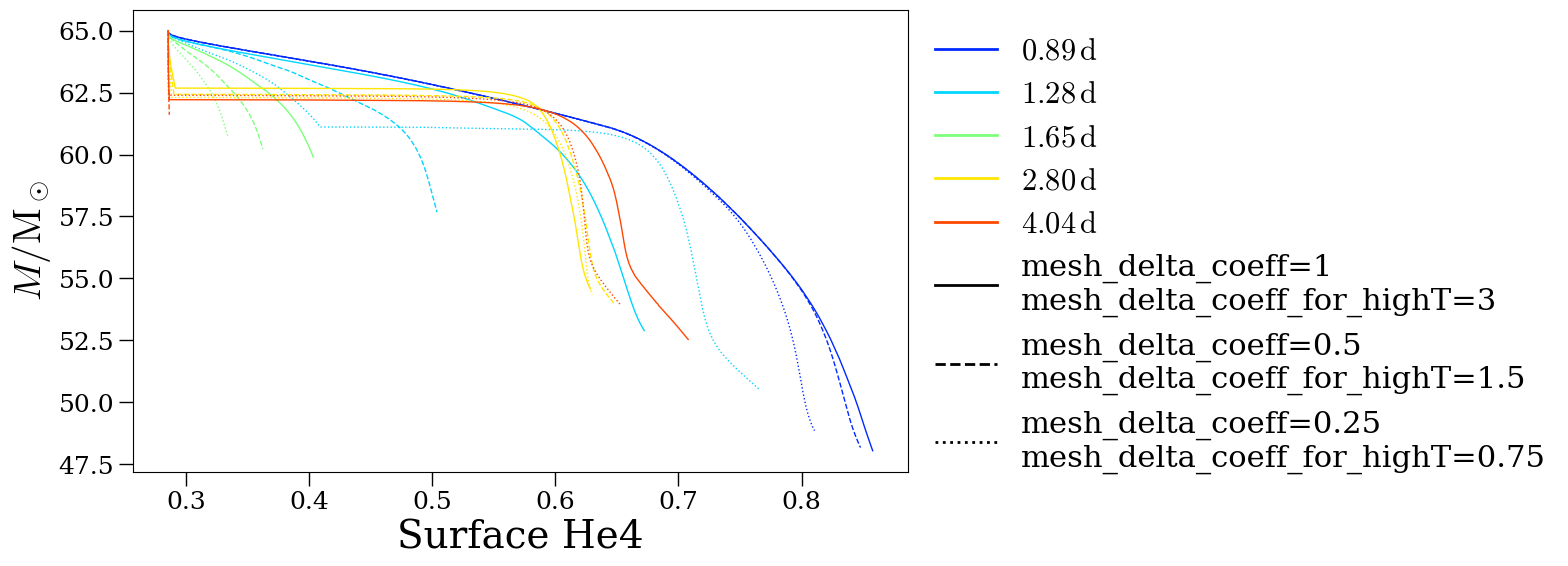

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='surface_he4',
    y='star_mass',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$M/\\mathrm{M}_\\odot$')

Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

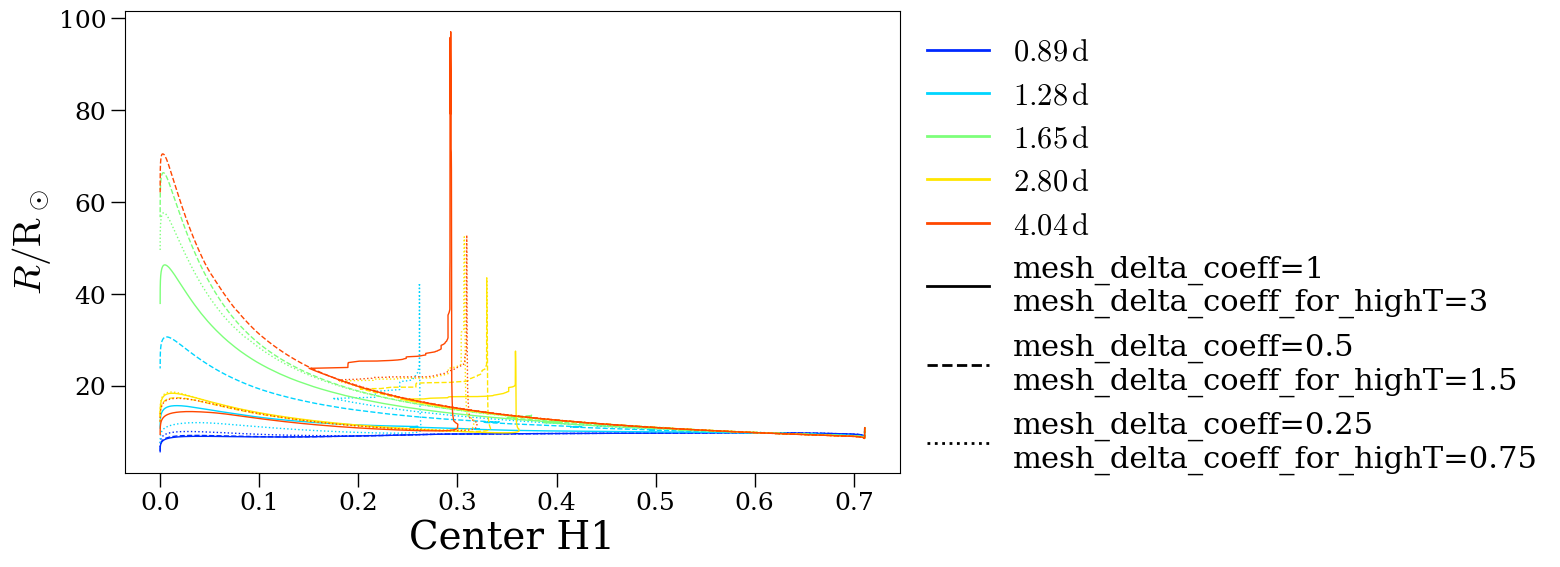

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='center_h1',
    y='radius',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

Text(0.6, 2.2, 'pp chain')

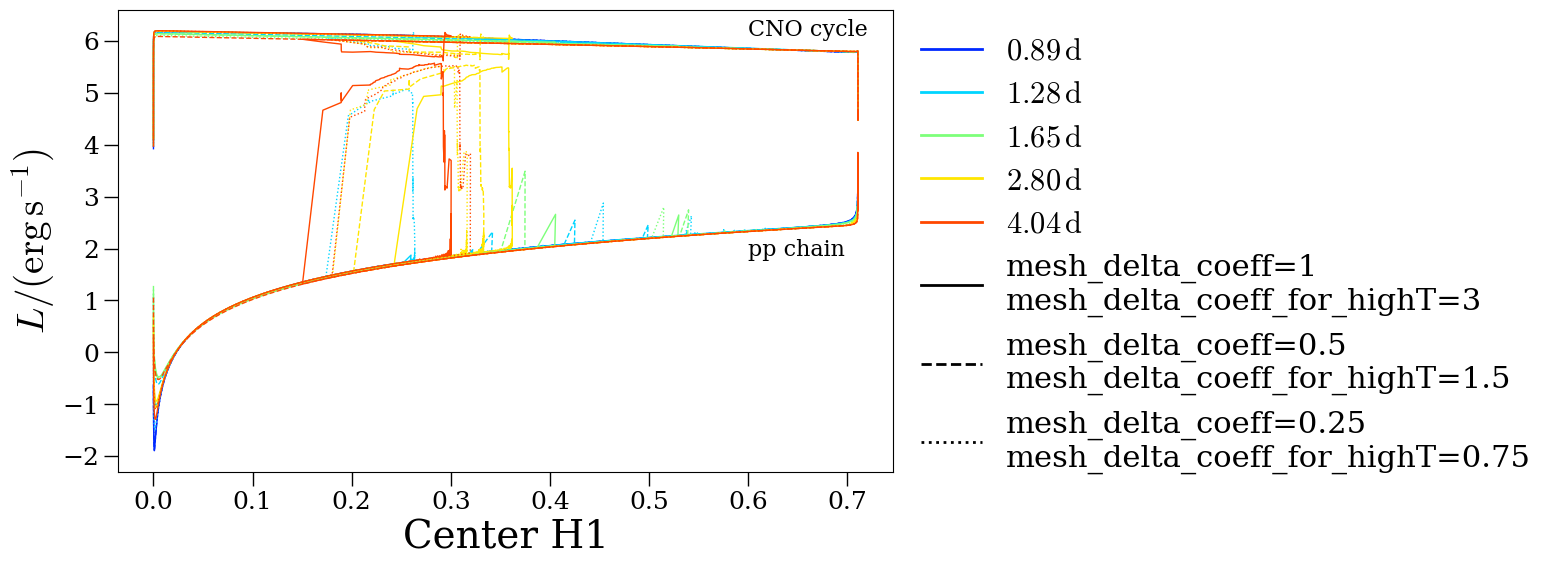

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

settings = dict(
    x='center_h1',
    y='pp',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)
ax = history_plot(ax, **settings)

settings = dict(
    x='center_h1',
    y='cno',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)
ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$L/(\\mathrm{erg}\\,\\mathrm{s}^{-1})$')
#ax.set_ylim(-6.5, -4)

ax.text(0.6, 6.0, 'CNO cycle', ha='left', va='bottom', transform=ax.transData, fontsize=16)
ax.text(0.6, 2.2, 'pp chain', ha='left', va='top', transform=ax.transData, fontsize=16)

Text(0, 0.5, '$\\log T_\\mathrm{center}/\\mathrm{K}$')

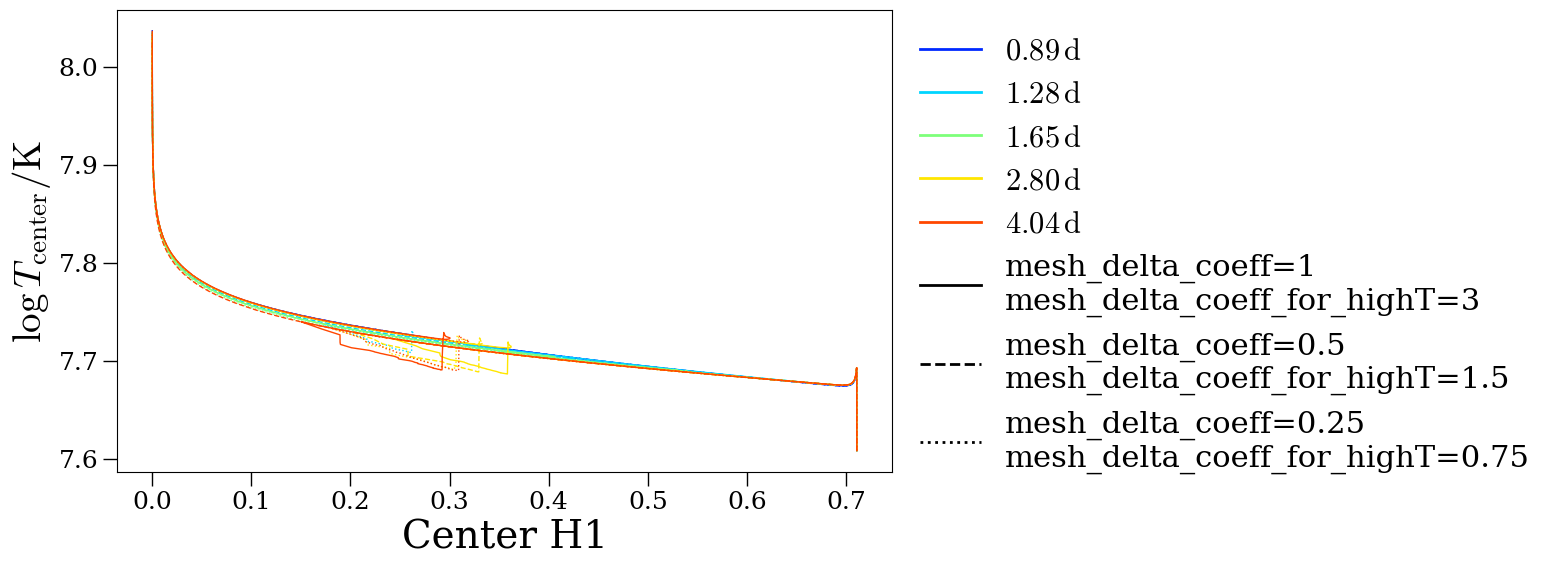

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

settings = dict(
    x='center_h1',
    y='log_center_T',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)
ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$\\log T_\\mathrm{center}/\\mathrm{K}$')
#ax.set_ylim(-6.5, -4)

## Scatter plots

In [ ]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [ ]:
test_case = model_dict1['65.0']['4.04']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

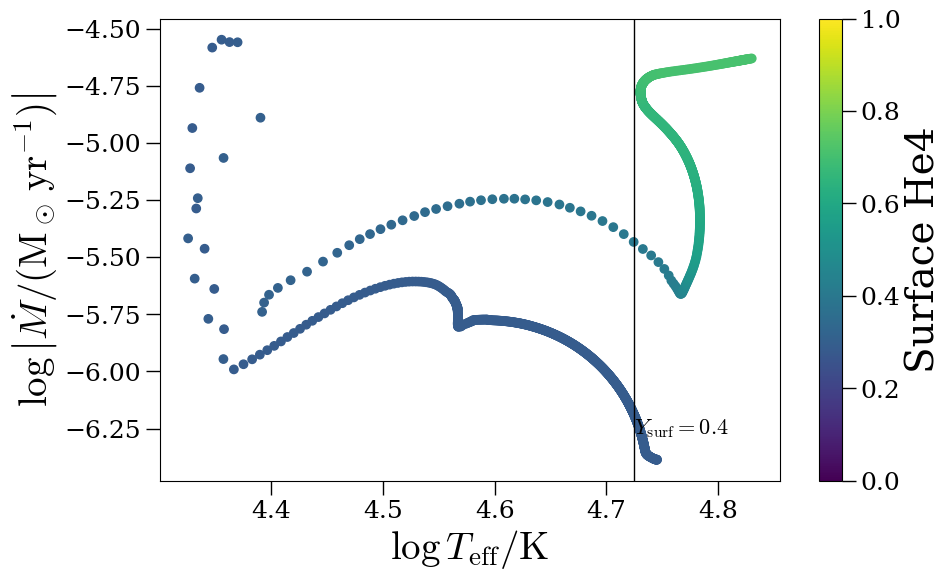

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = h.log_Teff
zams_i = np.where(h.surf_avg_omega_div_omega_crit>0)[0][0]
he04_i = np.where(h.surface_he4 >= 0.4)[0][0]
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]
c = cm.viridis(h.surface_he4[zams_i:])
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]

#ax.plot(x, normarr(h.star_mass), 'k-', lw=1, label='normalized $\\log M$')
#ax.plot(x, normarr(h.radius), 'r-', lw=1, label='normalized $\\log R$')
#ax.plot(x, h.surface_he4, 'g-', lw=1, label='Surf. He4')
#ax.plot(x, h.center_h1, 'g--', lw=1, label='Center. H1')
#ax.plot(x, h.surf_avg_omega_div_omega_crit, 'b-', lw=1, label='$\\Omega/\\Omega_\\mathrm{c}$')
ax.scatter(x[zams_i:], h.log_abs_mdot[zams_i:], c=c, label='normalized $\\log \\dot{M}$')

ylim = ax.get_ylim()
ax.vlines(x[he04_i], *ylim, color='k', ls='-', lw=1)
ax.text(x[he04_i], -6.25, '$Y_\\mathrm{surf}=0.4$', ha='left', va='center', transform=ax.transData,
        fontsize=16)
#ax.vlines(x[he07_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he07_i], -6.25, '$Y_\\mathrm{surf}=0.7$', ha='left', va='center', transform=ax.transData,
        #fontsize=16)
ax.set_ylim(*ylim)

#ax.hlines(0.4, 0, 3.5, color='k', ls='--', lw=1)
#ax.hlines(0.7, 0, 3.5, color='k', ls='--', lw=1)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')

#ax.legend(ncol=3, loc='lower left', bbox_to_anchor=(0,1))
cb = fig.colorbar(ScalarMappable(Normalize(vmin=0, vmax=1), cmap=cm.viridis), ax=ax)
cb.set_label('Surface He4')


#ax.set_xlim(0, 1)
#ax.set_yscale('log')
#ax.invert_yaxis()

#ax.set_yscale('log')

In [ ]:
test_case = model_dict2['65.0']['4.04']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

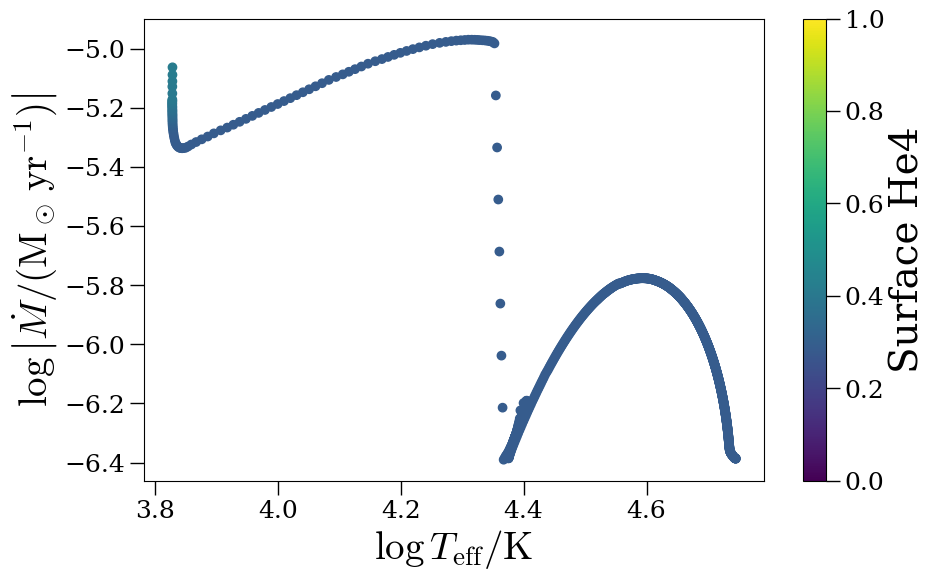

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = h.log_Teff
zams_i = np.where(h.surf_avg_omega_div_omega_crit>0)[0][0]
#he04_i = np.where(h.surface_he4 >= 0.4)[0][0]
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]
c = cm.viridis(h.surface_he4[zams_i:])
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]

#ax.plot(x, normarr(h.star_mass), 'k-', lw=1, label='normalized $\\log M$')
#ax.plot(x, normarr(h.radius), 'r-', lw=1, label='normalized $\\log R$')
#ax.plot(x, h.surface_he4, 'g-', lw=1, label='Surf. He4')
#ax.plot(x, h.center_h1, 'g--', lw=1, label='Center. H1')
#ax.plot(x, h.surf_avg_omega_div_omega_crit, 'b-', lw=1, label='$\\Omega/\\Omega_\\mathrm{c}$')
ax.scatter(x[zams_i:], h.log_abs_mdot[zams_i:], c=c, label='normalized $\\log \\dot{M}$')

ylim = ax.get_ylim()
#ax.vlines(x[he04_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he04_i], -6.25, '$Y_\\mathrm{surf}=0.4$', ha='left', va='center', transform=ax.transData,
#        fontsize=16)
#ax.vlines(x[he07_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he07_i], -6.25, '$Y_\\mathrm{surf}=0.7$', ha='left', va='center', transform=ax.transData,
        #fontsize=16)
ax.set_ylim(*ylim)

#ax.hlines(0.4, 0, 3.5, color='k', ls='--', lw=1)
#ax.hlines(0.7, 0, 3.5, color='k', ls='--', lw=1)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')

#ax.legend(ncol=3, loc='lower left', bbox_to_anchor=(0,1))
cb = fig.colorbar(ScalarMappable(Normalize(vmin=0, vmax=1), cmap=cm.viridis), ax=ax)
cb.set_label('Surface He4')


#ax.set_xlim(0, 1)
#ax.set_yscale('log')
#ax.invert_yaxis()

#ax.set_yscale('log')

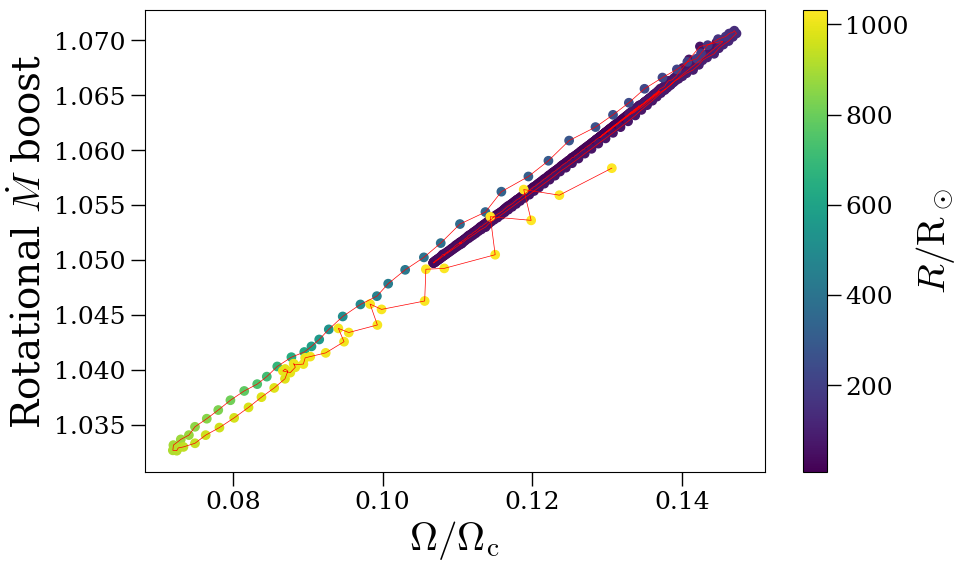

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.viridis

y = h.rotational_mdot_boost[i_start:i_end:i_step]
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.radius[i_start:i_end:i_step]
c = cmap(normarr(cdata))

ax.scatter(x, y, c=c, alpha=1)
ax.plot(x, y, c='r', lw=0.5, alpha=1)
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('Rotational $\\dot{M}$ boost')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('$R/\\mathrm{R}_\\odot$')


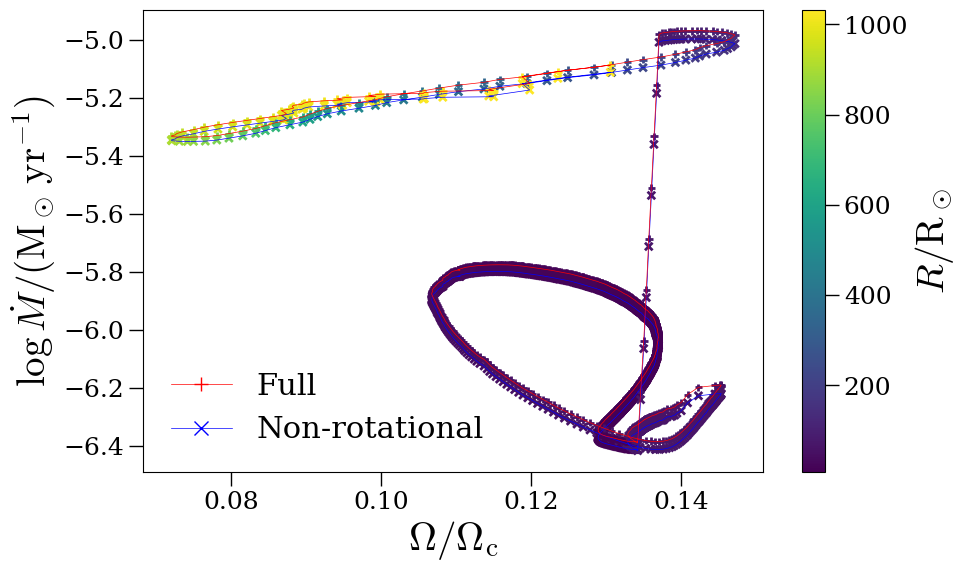

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.viridis

y1 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
y2 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step])#-10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.radius[i_start:i_end:i_step]
c = cmap(normarr(cdata))

ax.scatter(x, y1, c=c, marker='x', alpha=1, s=30)
ax.plot(x, y1, c='b', lw=0.5, alpha=1)
ax.scatter(x, y2, c=c, marker='+', alpha=1, s=30)
ax.plot(x, y2, c='r', lw=0.5, alpha=1)
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('$R/\\mathrm{R}_\\odot$')

handles = []
handles.append(Line2D([], [], color='r', ls='-', lw=0.5, marker='+', ms=10, label='Full'))
handles.append(Line2D([], [], color='b', ls='-', lw=0.5, marker='x', ms=10, label='Non-rotational'))
ax.legend(handles=handles, frameon=False)


Error in callback <function _draw_all_if_interactive at 0x15551cff7370> (for post_execute):


KeyboardInterrupt: 

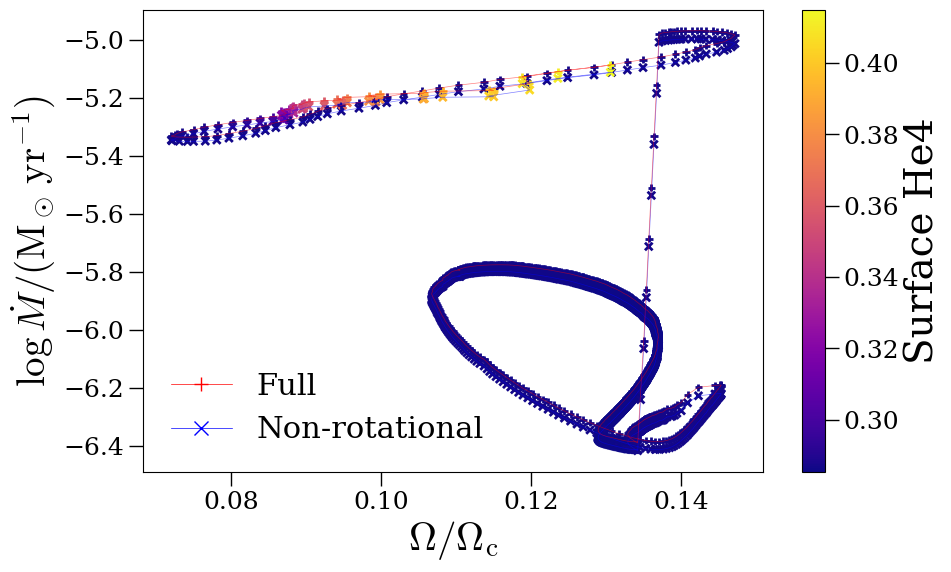

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.plasma

y1 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
y2 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step])#-10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.surface_he4[i_start:i_end:i_step]
c = cmap(normarr(cdata))
he04_i = np.where(h.surface_he4 <= 0.4)[0][0]

ax.scatter(x, y1, c=c, marker='x', alpha=1, s=30)
ax.plot(x, y1, c='b', lw=0.5, alpha=0.5)
ax.scatter(x, y2, c=c, marker='+', alpha=1, s=30)
ax.plot(x, y2, c='r', lw=0.5, alpha=0.5)

ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('Surface He4')

handles = []
handles.append(Line2D([], [], color='r', ls='-', lw=0.5, marker='+', ms=10, label='Full'))
handles.append(Line2D([], [], color='b', ls='-', lw=0.5, marker='x', ms=10, label='Non-rotational'))
ax.legend(handles=handles, frameon=False)


In [ ]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dict2['65.0']['4.04']/'LOGS'))
mm.scrubHistory()

AttributeError: No attribute head_names

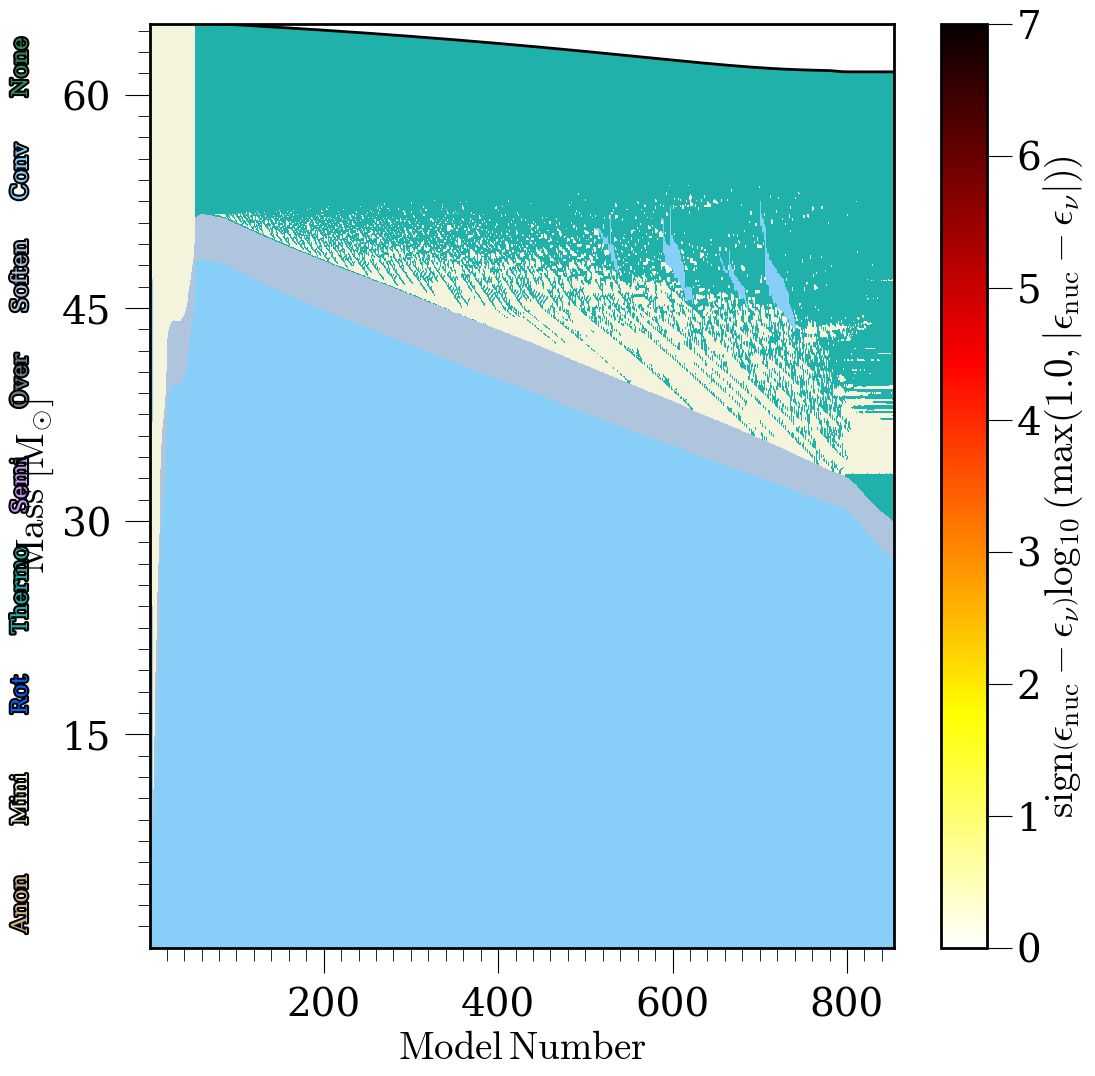

In [ ]:
p = mp.plot()
p.plotKip(mm)

In [ ]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dict1['65.0']['4.04']/'LOGS'))
mm.scrubHistory()

AttributeError: No attribute head_names

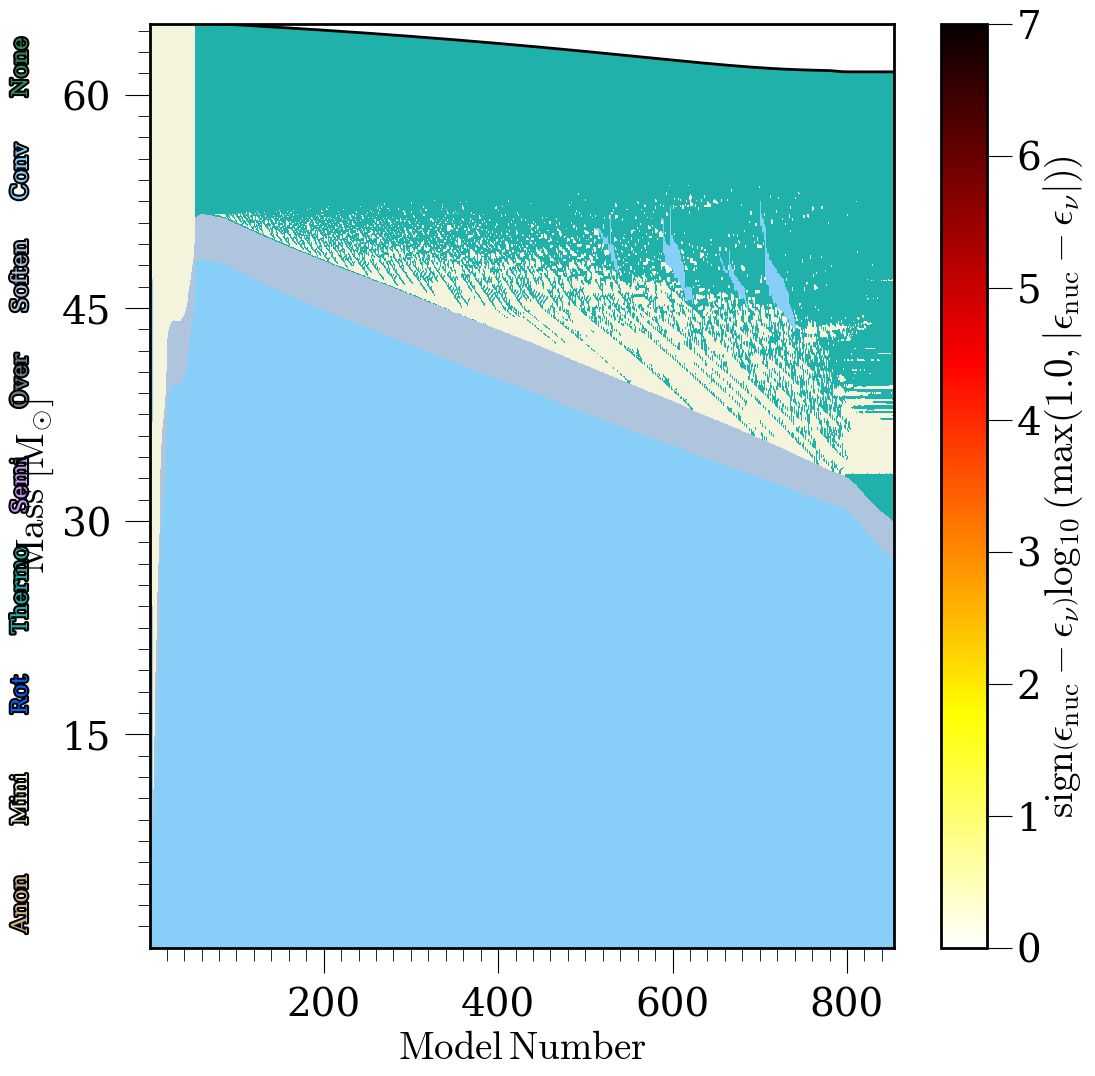

In [ ]:
p = mp.plot()
p.plotKip(mm)

#### Internal rotation

In [20]:
test_case = model_dict1['65.0']['1.28']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

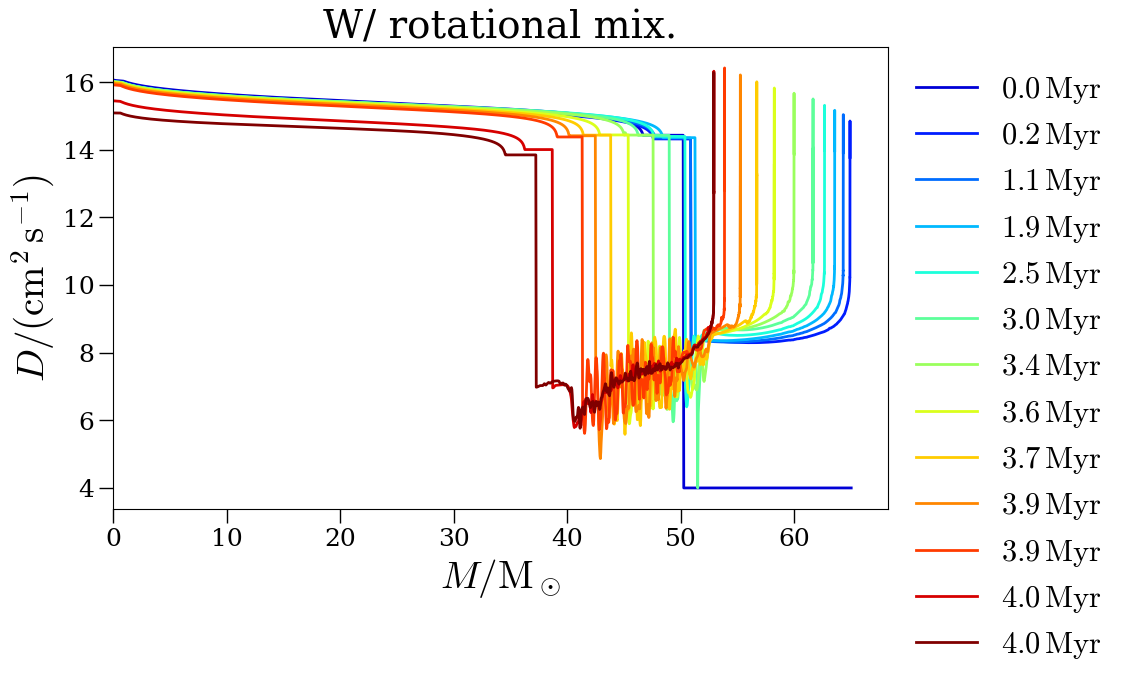

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_D_mix, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    ax.set_xlim(0)
    
    

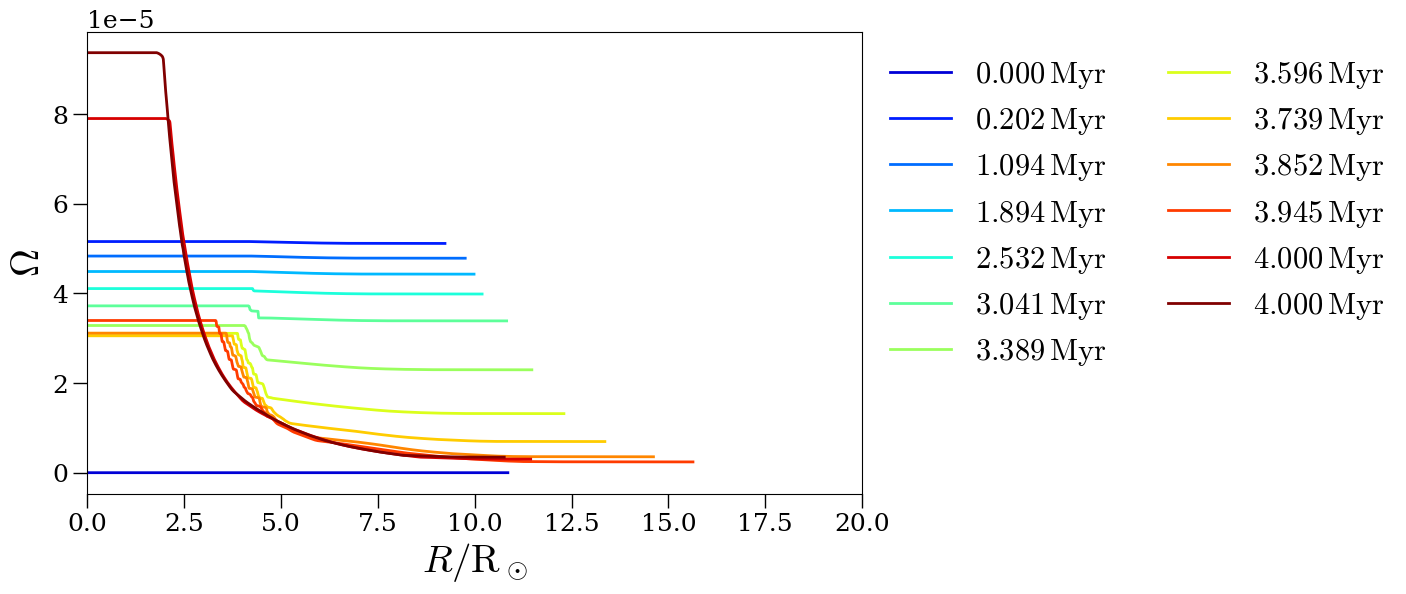

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.radius, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    ax.set_xlim(0, 20)
    
    

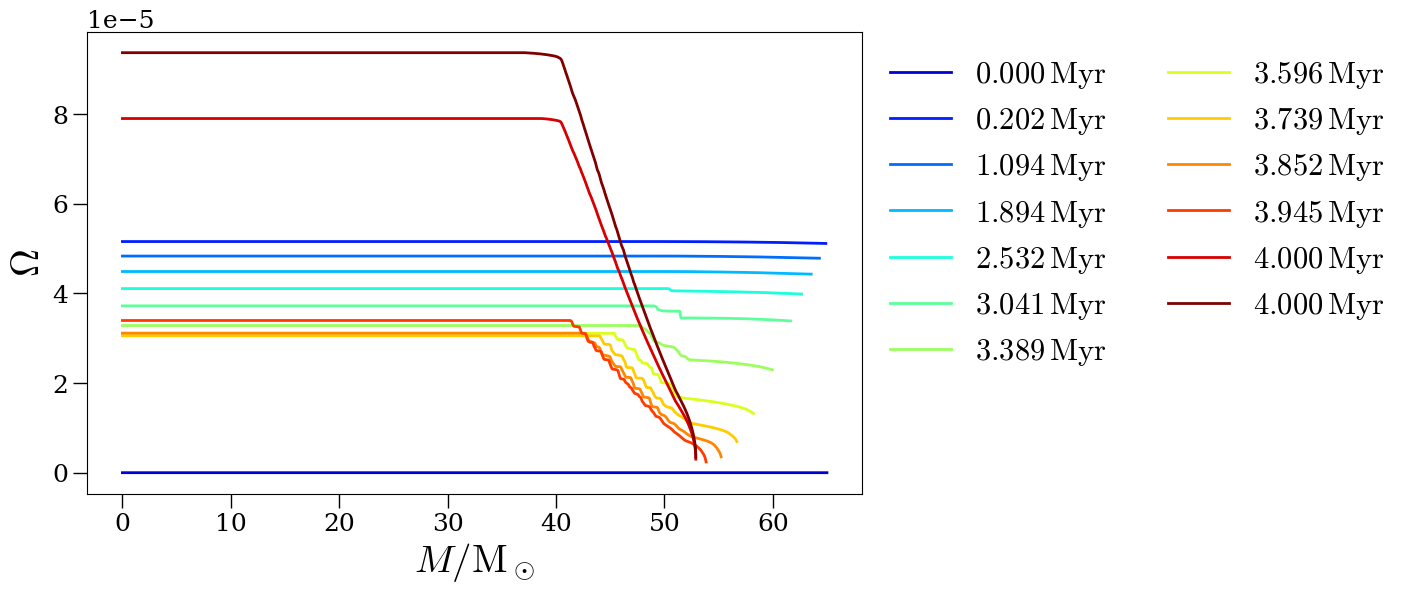

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    #ax.set_xlim(0, 20)
    
    

In [ ]:
test_case = model_dict2['65.0']['4.04']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

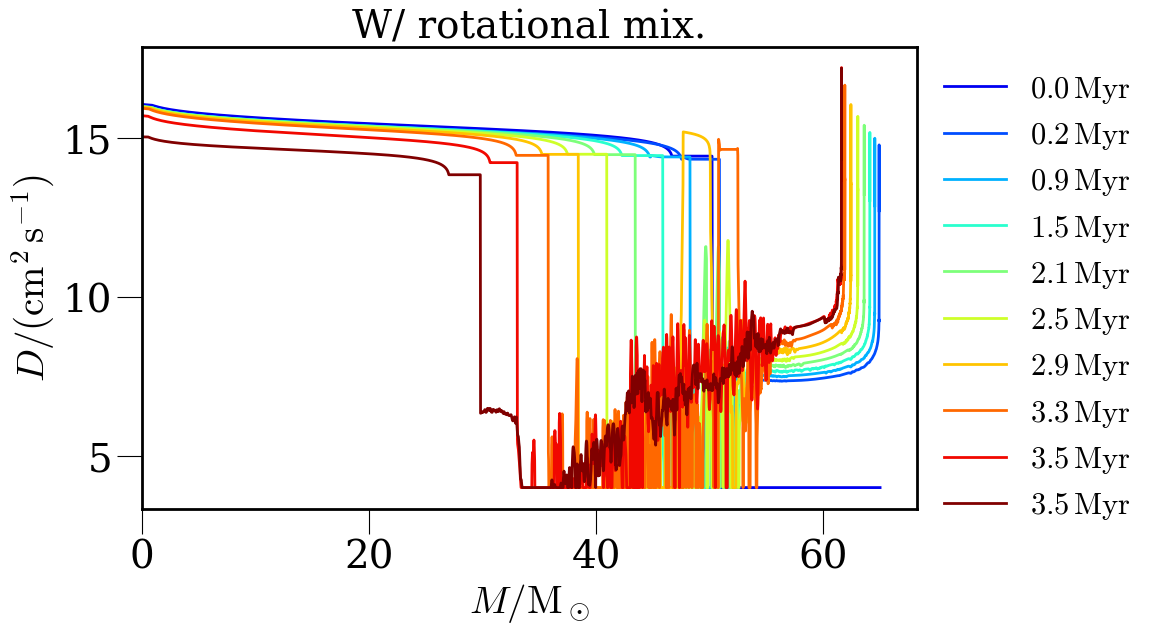

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_D_mix, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    ax.set_xlim(0)
    
    

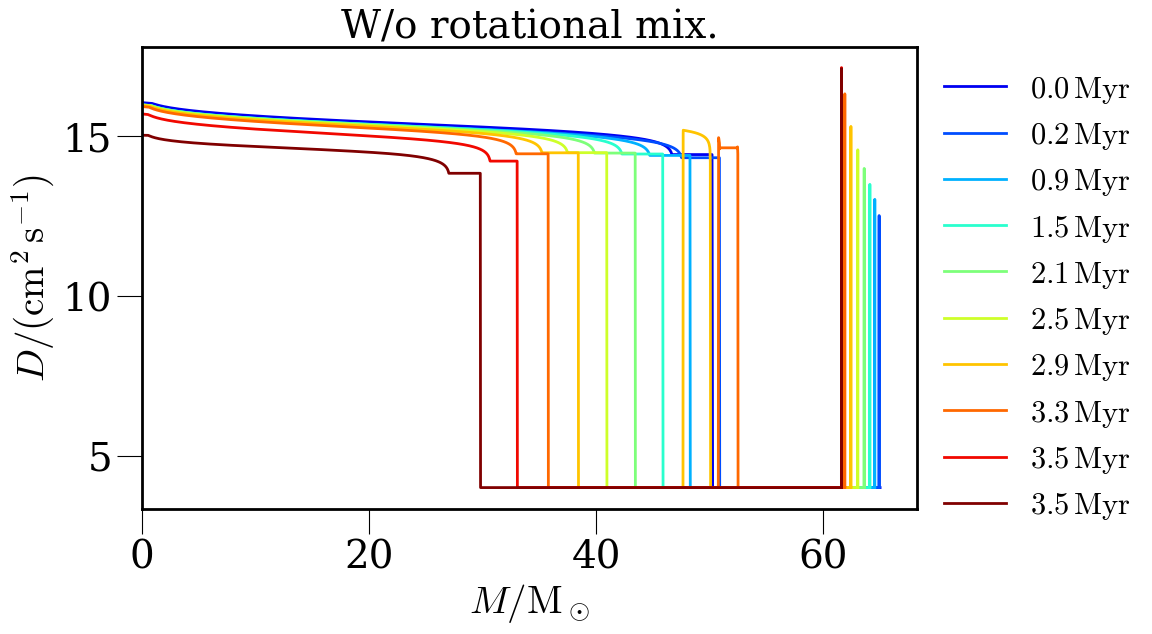

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_D_mix_non_rotation, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/o rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    ax.set_xlim(0)
    
    

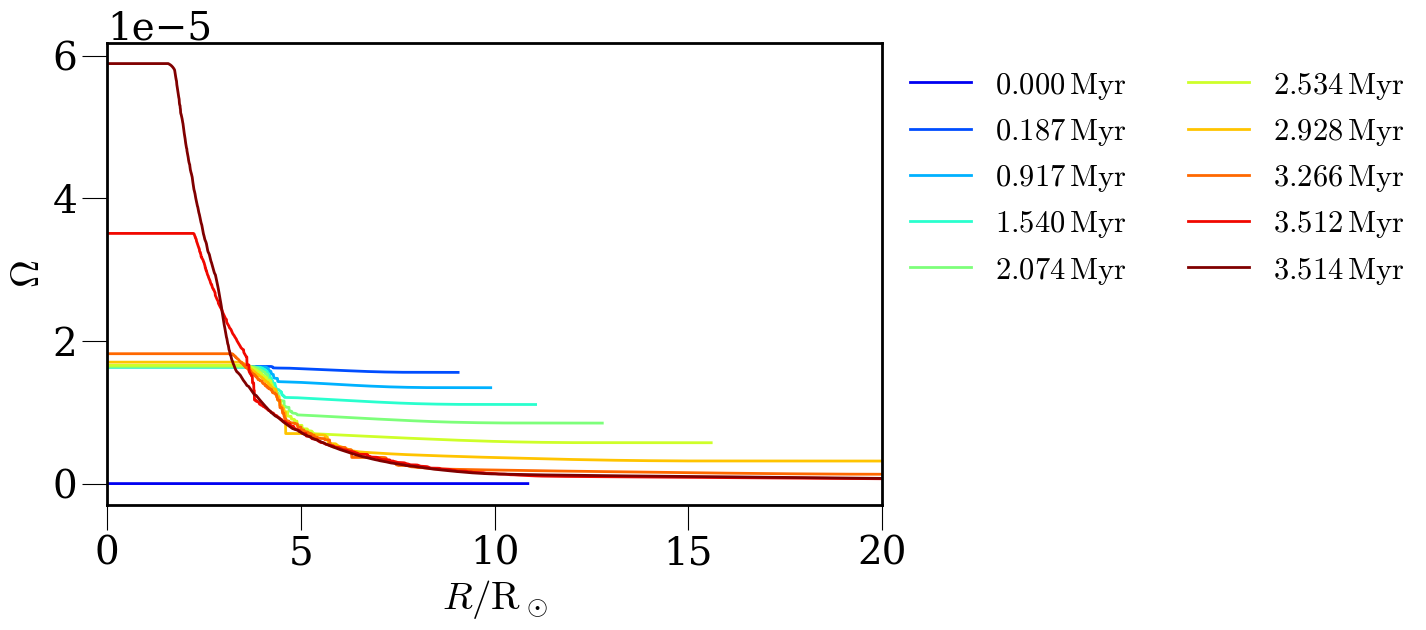

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.radius, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    ax.set_xlim(0, 20)
    
    

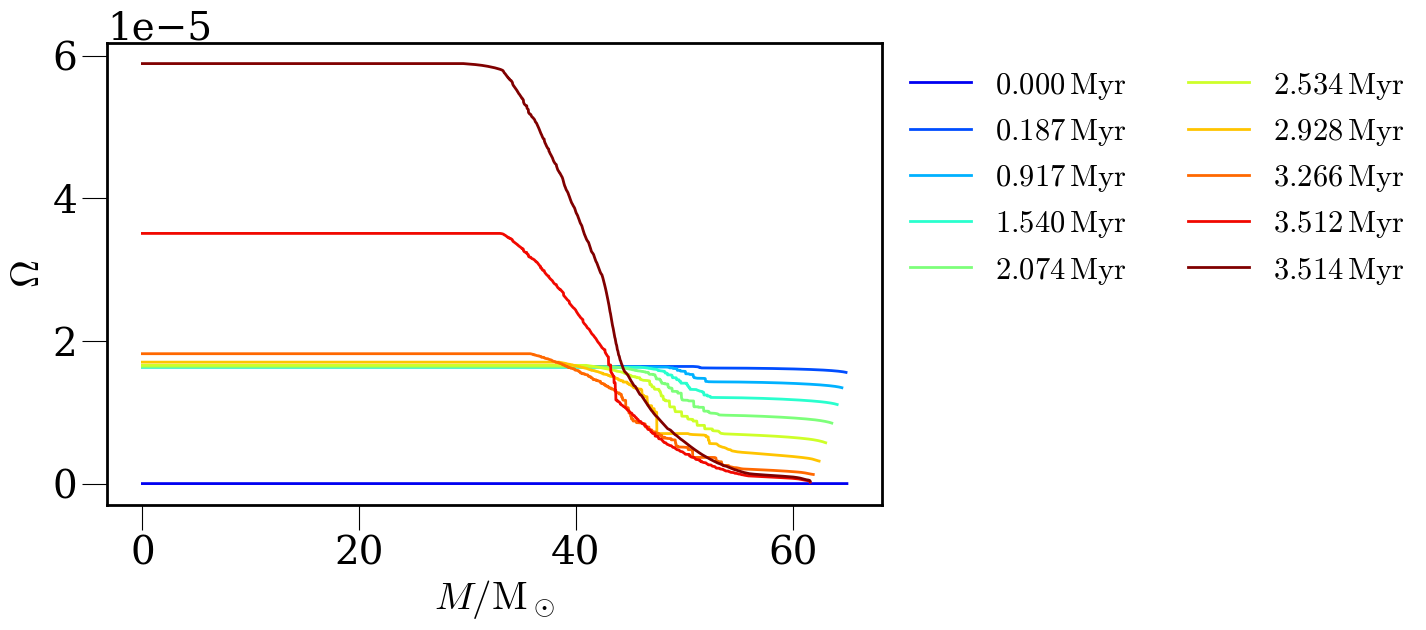

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    #ax.set_xlim(0, 20)
    
    

## Mixing timescale

In [ ]:
def tau_mix(prof):
    mix_types = prof.mixing_type
    first_overshoot_i = np.where(mix_types == 2)[0][0]

    r = prof.radius[:first_overshoot_i]
    d = 10.**prof.log_D_mix[:first_overshoot_i]
    d_nonrot = 10.**prof.log_D_mix_non_rotation[:first_overshoot_i]
    h_p = prof.pressure_scale_height[:first_overshoot_i] * u.Rsun.to(u.cm)
    dt_mix = h_p**2 / d
    dt_mix_nonrot = h_p**2 / d_nonrot

    mix_tscale = -simpson(x=r, y=dt_mix) * u.s.to(u.yr)
    mix_tscale_nonrot = -simpson(x=r, y=dt_mix_nonrot) * u.s.to(u.yr)

    return mix_tscale, mix_tscale_nonrot

In [ ]:
all_paths = [model_dict[k1][k2] for k1 in model_dict.keys() for k2 in model_dict[k1].keys()] 

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

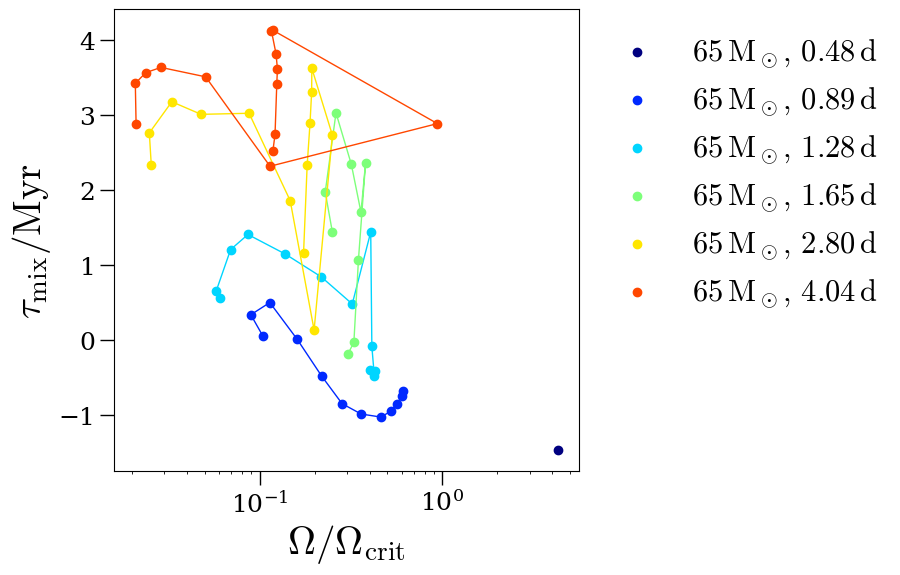

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.omega_div_omega_crit[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

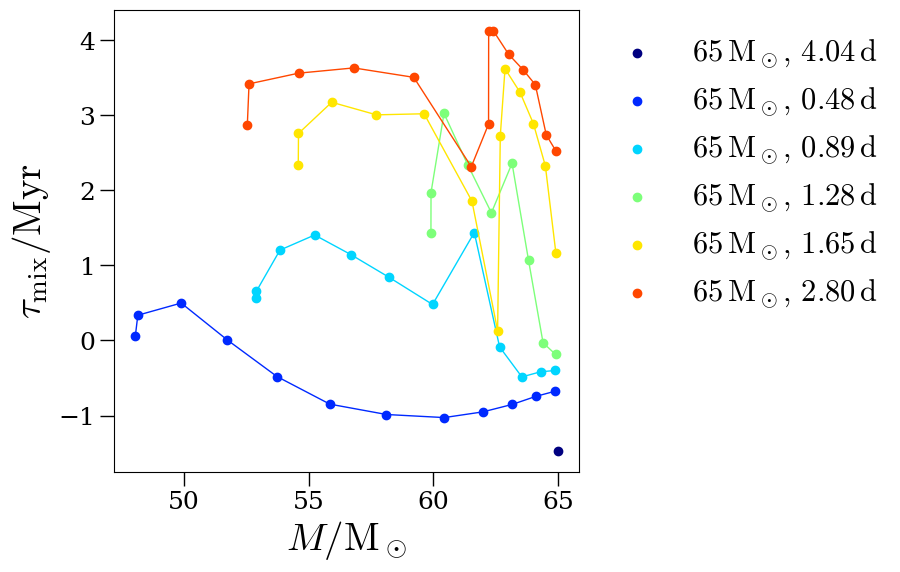

In [ ]:

fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.mass[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
#ax.set_xscale('log')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

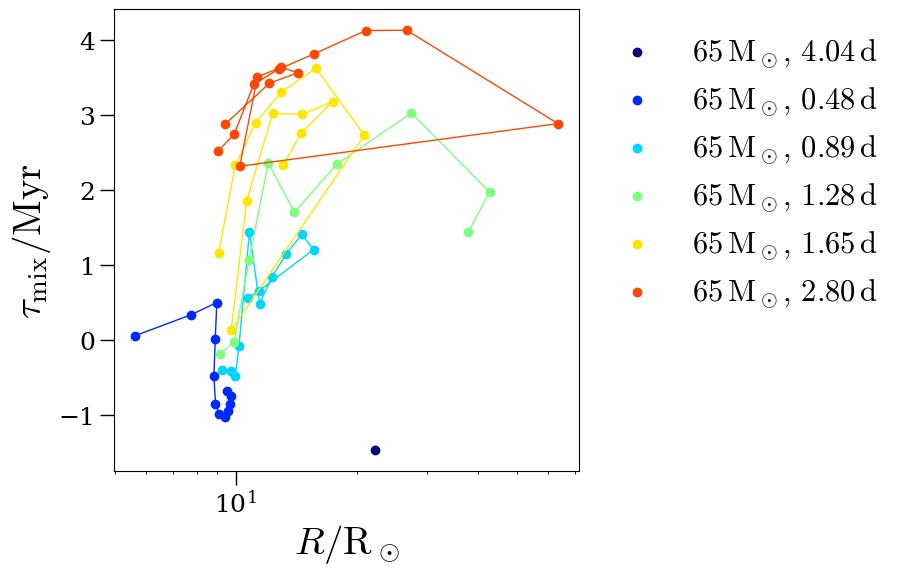

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.radius[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')